# Conclusion

XGBoost with kfolds=5, and pruned parameter values found with `RandomizedSearchCV`.

No model accuries beat the target 

## HOME_TEAM_WINS

Target to beat - 59.1% home winrate

Achieved - **59% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|56%|54%|43%|
|max_depth|58%|55%|53%|
|reg_lambda|54%|54%|53%|
|learning rate|59%|58%|55%|
|gamma|60%|59%|57%|
|scale_pos_weight|59%|59%|53%|

## HOME_HIGHER_FG_PCT

Target to beat - 55.0% rate of home having higher FGP

Achieved - **55% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|52%|51%|50%|
|max_depth|54%|53%|52%|
|reg_lambda|52%|51%|50%|
|learning rate|51%|50%|49%|
|gamma|55%|55%|54%|
|scale_pos_weight|55%|54%|54%|

## HOME_HIGHER_FG3_PCT

Target to beat - 50.8% rate of home having higher FG3

Achieved - **51% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|49%|49%|49%|
|max_depth|51%|50%|49%|
|reg_lambda|50%|50%|49%|
|learning rate|51%|50%|49%|
|gamma|51%|51%|40%|
|scale_pos_weight|51%|51%|49%|

## HOME_HIGHER_FT_PCT

Target to beat - 49.5% rate of home having higher FTP

Achieved - **51% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|51%|50%|49%|
|max_depth|50%|50%|49%|
|reg_lambda|51%|50%|49%|
|learning rate|50%|50%|50%|
|gamma|51%|50%|49%|
|scale_pos_weight|50%|49%|48%|

## HOME_HIGHER_AST

Target to beat - 55.0% rate of home having higher AST

Achieved - **55% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|52%|51%|51%|
|max_depth|53%|52%|52%|
|reg_lambda|52%|52%|51%|
|learning rate|55%|54%|54%|
|gamma|55%|55%|44%|
|scale_pos_weight|55%|54%|54%|

## HOME_HIGHER_REB

Target to beat - 53.4% rate of home having higher REB

Achieved - **53% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|51%|51%|50%|
|max_depth|51%|50%|50%|
|reg_lambda|51%|50%|50%|
|learning rate|53%|51%|50%|
|gamma|53%|53%|53%|
|scale_pos_weight|53%|53%|53%|


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

## Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [3]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [5]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [6]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [7]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [8]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [9]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

## Datasets

In [10]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [11]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  ...  PPG_total_away  \
0                0.000000           0.000000  ...        0.000000   
1                0.000000           0.000000  ...        0.000000   
2                0.000000           0.000000  ...        0.000000   
3                0.000000           0.000000  ...        0.000000   
4                0.000000           0.000000  ...        0.000000   
...                   ...                ...  ...             ...   
23515            0.353000           0.691000  ...       92.000000   
23516            0.383000           0.619000  ...      108.000000   
23517            0.329333           0.704667  ...      111.333333   
23518            0.321500           0.704500  ...       93.333333   
23519            0.305333           0.758000  ...      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
0               0.000000            0.000000           0.000000   
1               0.000000            0.000000           0.000000   
2               0.000000            0.000000           0.000000   
3               0.000000            0.000000           0.000000   
4               0.000000            0.000000           0.000000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  TEAM_ID_away  TEAM_ID_home  W_PCT_away  \
0            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
1            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
2            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
3            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
4            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
...               ...             ...           ...           ...         ...   
23515       26.000000       35.000000  1.610613e+09  1.610613e+09    0.000000   
23516       23.000000       42.000000  1.610613e+09  1.610613e+09    1.000000   
23517       24.000000       56.000000  1

## Attach target columns to dataset

In [12]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [13]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [14]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
19         104.000000           0.527000            0.429000   
21          86.000000           0.380000            0.188000   
22          86.000000           0.352000            0.222000   
23          58.000000           0.457000            0.667000   
24          87.500000           0.432000            0.420000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
19              0.657000       22.000000       33.000000      101.000000   
21              0.852000       19.000000       37.000000      101.000000   
22              0.647000       15.000000       55.000000       80.000000   
23              0.700000       10.000000       31.000000       89.000000   
24              0.672000       20.500000       43.000000       79.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
19              0.467000            0.444000           0.871000   
21              0.464000            0.250000           0.679000   
22              0.350000            0.429000           0.750000   
23              0.462000            0.214000           0.538000   
24              0.329000            0.143000           0.897000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  
19          19.000000       39.000000    1.000000    1.000000  
21          22.000000       47.000000    1.000000    0.000000  
22          18.000000       45.000000    0.000000    1.000000  
23          21.000000       36.000000    0.000000    0.000000  
24           7.000000       44.000000    0.000000    0.500000  
...               ...             ...         ...         ...  
23515       26.000000       35.000000    0.000000    1.000000  
23516       23.000000       42.000000    1.000000    0.000000  
23517       24.000000       56.000000    0.333333    1.000000  
23518       20.000000       41.666667    0.666667    0.000000  
23519       29.666667       45.000000    0.333333    0.333333  

[23147 rows x 14 columns]

## Do hyperparameters searches

In [16]:
from sklearn.metrics import classification_report

In [17]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [18]:
from sklearn.utils.class_weight import compute_sample_weight

In [19]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [20]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [21]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best XGBoost accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [22]:
from sklearn.model_selection import cross_validate

In [23]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    for train, test in kf.split(cumulative_stats_copy_df, target):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = cumulative_stats_copy_df.iloc[train], cumulative_stats_copy_df.iloc[test]
        y_train_dict[key], y_test_dict[key] = target.iloc[train], target.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [36]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            xgb.XGBClassifier(random_state=0,eval_metric='logloss'),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train tree w/o pruning

In [38]:
import warnings
warnings.filterwarnings("ignore")

i=0
WINNER:

Best XGBoost accuracy ({}): 0.54
              precision    recall  f1-score   support

           0       0.40      0.19      0.26      1953
           1       0.57      0.79      0.66      2677

    accuracy                           0.54      4630
   macro avg       0.49      0.49      0.46      4630
weighted avg       0.50      0.54      0.49      4630



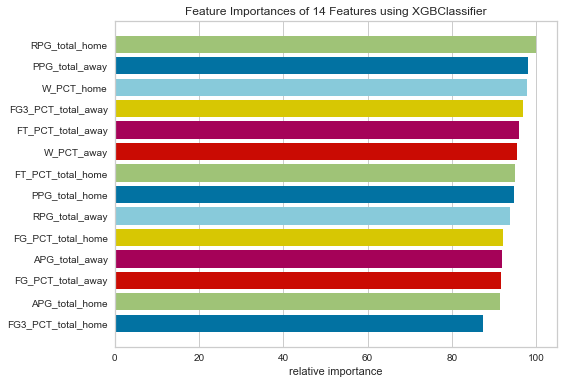

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({}): 0.54
              precision    recall  f1-score   support

           0       0.40      0.25      0.31      1865
           1       0.59      0.74      0.66      2765

    accuracy                           0.54      4630
   macro avg       0.50      0.50      0.48      4630
weighted avg       0.51      0.54      0.52      4630



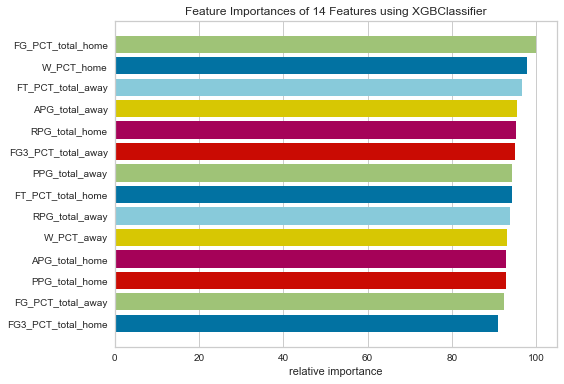

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.39      0.23      0.29      1836
           1       0.60      0.77      0.67      2793

    accuracy                           0.55      4629
   macro avg       0.50      0.50      0.48      4629
weighted avg       0.52      0.55      0.52      4629



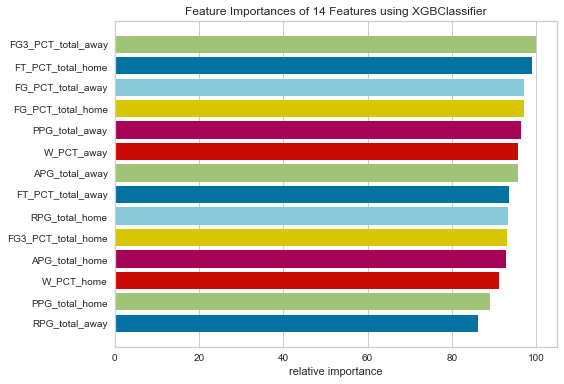

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.42      0.21      0.28      1871
           1       0.60      0.80      0.68      2758

    accuracy                           0.56      4629
   macro avg       0.51      0.51      0.48      4629
weighted avg       0.53      0.56      0.52      4629



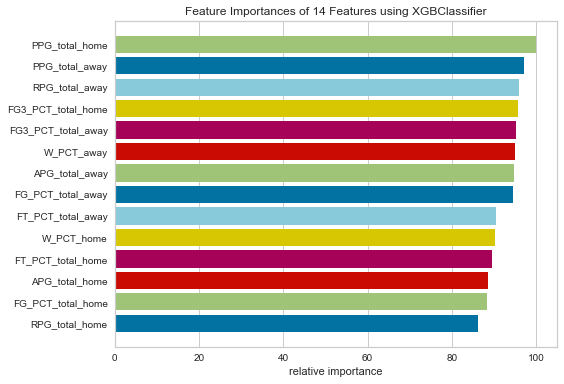

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.42      0.23      0.30      1913
           1       0.59      0.78      0.67      2716

    accuracy                           0.55      4629
   macro avg       0.51      0.50      0.48      4629
weighted avg       0.52      0.55      0.52      4629



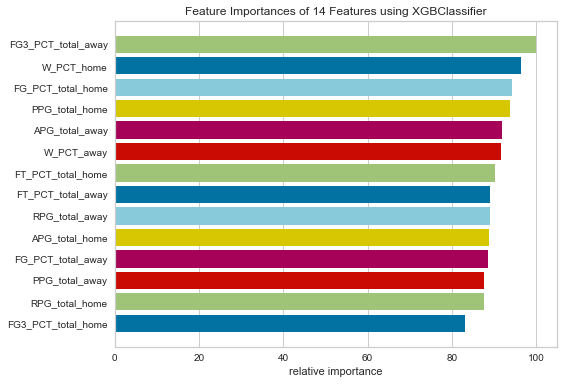

---------------------------------------------
Mean accuracy: 0.5489262686593628
Max accuracy: 0.5614603586087707
Min accuracy: 0.5375809935205184
i=5
FGP:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.45      0.31      0.36      2122
           1       0.54      0.68      0.60      2508

    accuracy                           0.51      4630
   macro avg       0.49      0.49      0.48      4630
weighted avg       0.50      0.51      0.49      4630



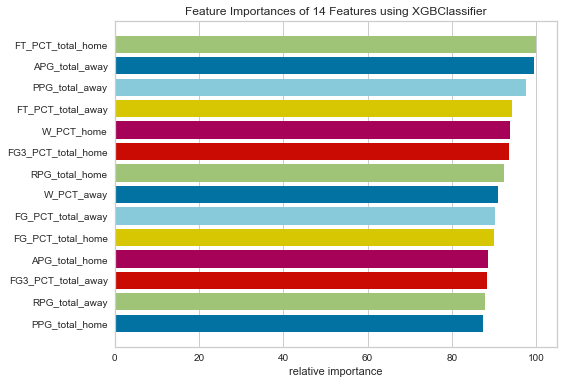

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.44      0.32      0.37      2071
           1       0.55      0.66      0.60      2559

    accuracy                           0.51      4630
   macro avg       0.49      0.49      0.49      4630
weighted avg       0.50      0.51      0.50      4630



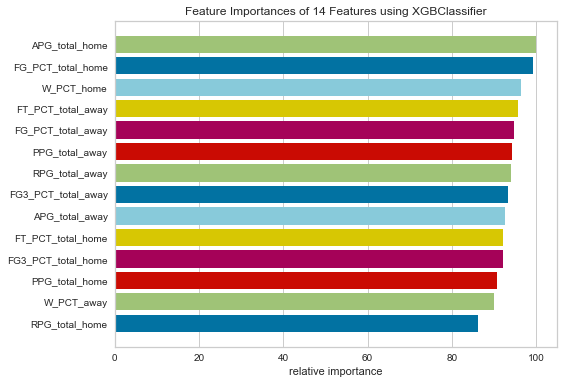

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.46      0.33      0.38      2082
           1       0.55      0.69      0.61      2547

    accuracy                           0.52      4629
   macro avg       0.51      0.51      0.50      4629
weighted avg       0.51      0.52      0.51      4629



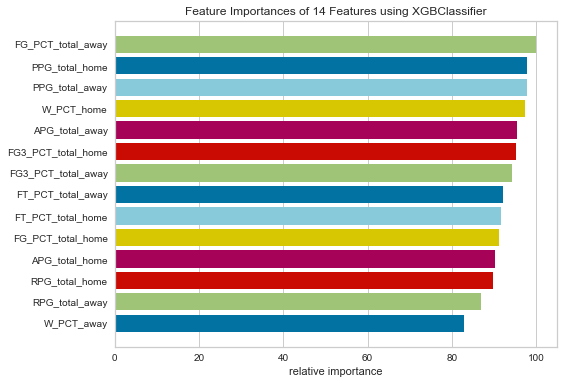

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.43      0.33      0.37      2041
           1       0.55      0.66      0.60      2588

    accuracy                           0.51      4629
   macro avg       0.49      0.49      0.49      4629
weighted avg       0.50      0.51      0.50      4629



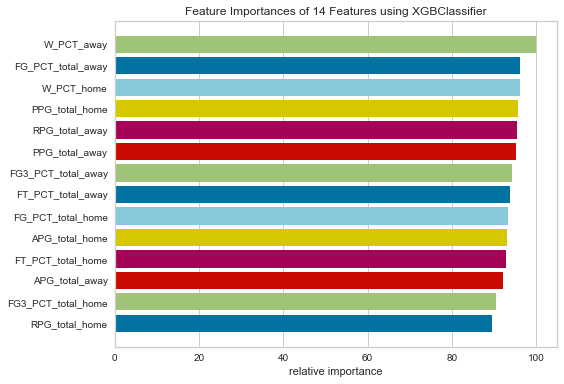

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.44      0.32      0.37      2060
           1       0.55      0.68      0.61      2569

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.51      0.52      0.50      4629



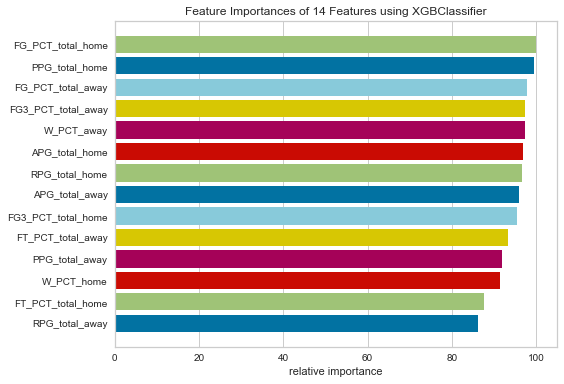

---------------------------------------------
Mean accuracy: 0.5141488395769557
Max accuracy: 0.5236552171095269
Min accuracy: 0.5086393088552916
i=10
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2266
           1       0.51      0.53      0.52      2364

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



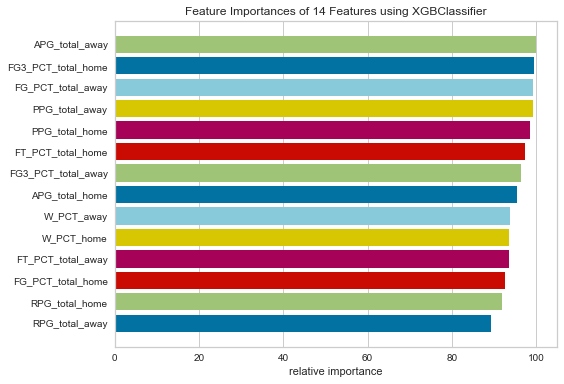

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2292
           1       0.50      0.52      0.51      2338

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



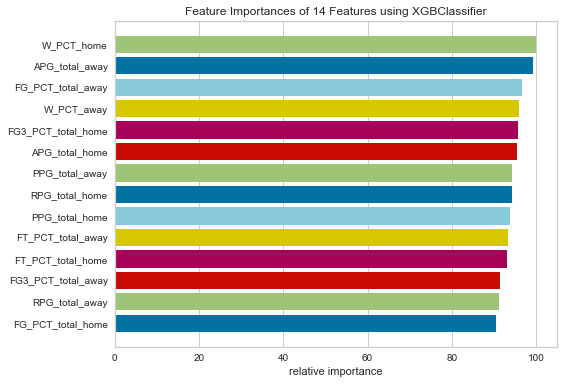

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.47      0.48      2223
           1       0.52      0.52      0.52      2406

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



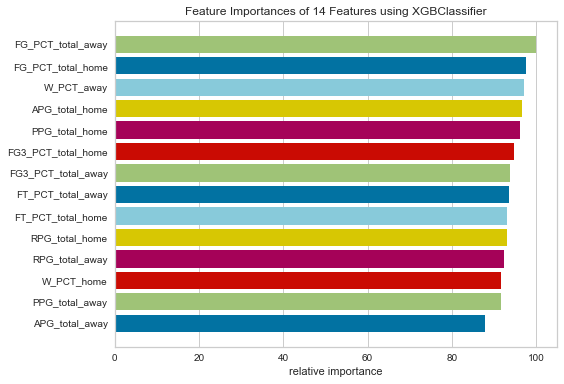

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      2265
           1       0.51      0.51      0.51      2364

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



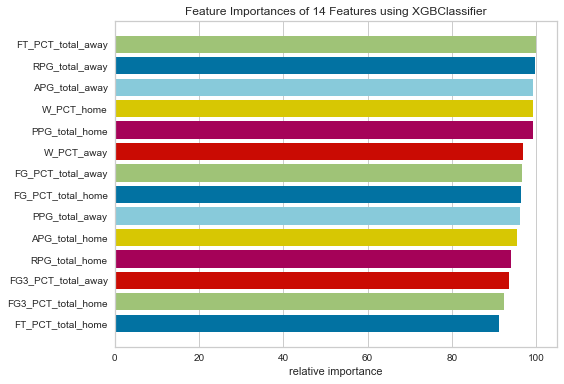

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2324
           1       0.50      0.53      0.51      2305

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



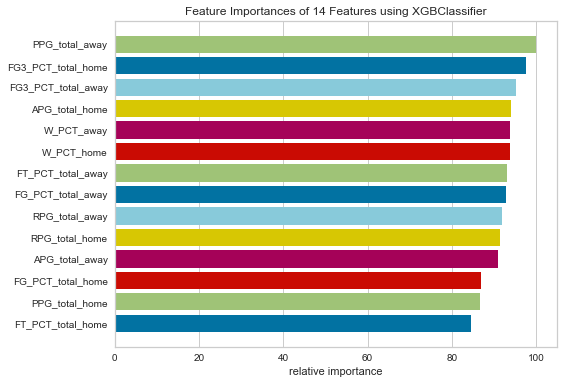

---------------------------------------------
Mean accuracy: 0.4975158837584633
Max accuracy: 0.49870410367170626
Min accuracy: 0.49557139771008857
i=15
FT:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2350
           1       0.51      0.50      0.50      2280

    accuracy                           0.51      4630
   macro avg       0.51      0.51      0.51      4630
weighted avg       0.51      0.51      0.51      4630



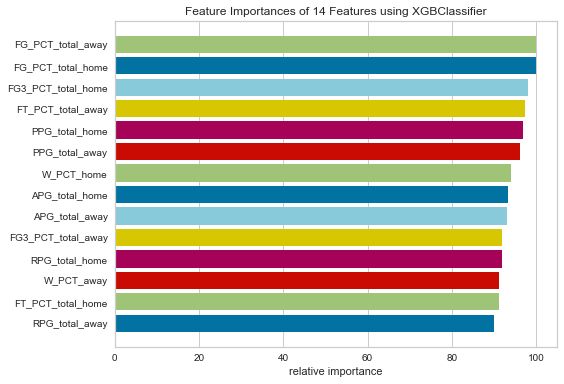

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      2324
           1       0.52      0.49      0.50      2306

    accuracy                           0.52      4630
   macro avg       0.52      0.52      0.52      4630
weighted avg       0.52      0.52      0.52      4630



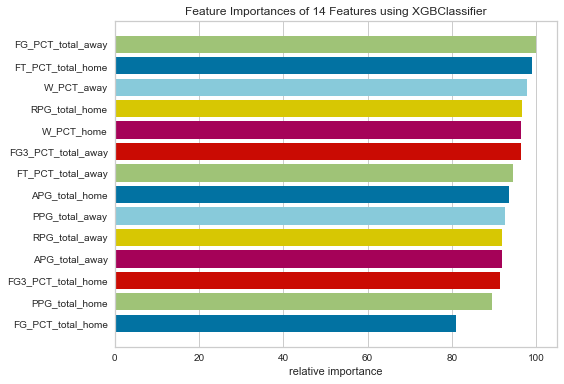

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2309
           1       0.50      0.46      0.48      2320

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



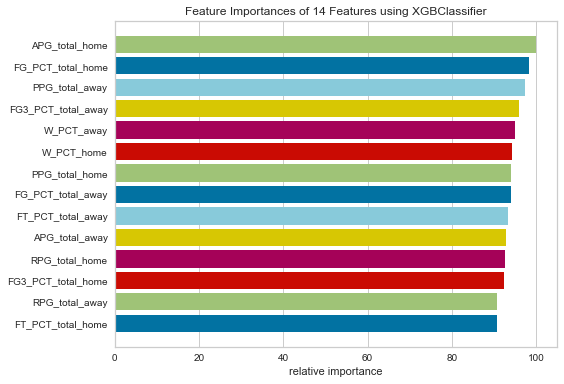

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({}): 0.49
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2390
           1       0.48      0.49      0.49      2239

    accuracy                           0.49      4629
   macro avg       0.49      0.49      0.49      4629
weighted avg       0.50      0.49      0.49      4629



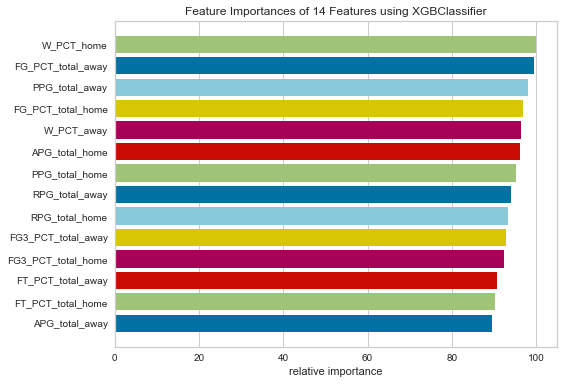

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.54      0.53      2332
           1       0.51      0.48      0.49      2297

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



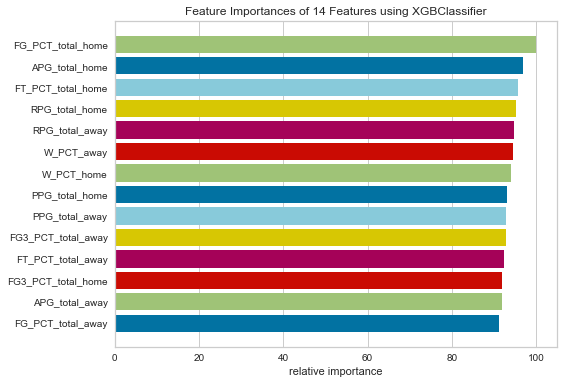

---------------------------------------------
Mean accuracy: 0.506641188730825
Max accuracy: 0.5185745140388769
Min accuracy: 0.4944912508101102
i=20
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.46      0.34      0.39      2120
           1       0.54      0.66      0.60      2510

    accuracy                           0.52      4630
   macro avg       0.50      0.50      0.49      4630
weighted avg       0.51      0.52      0.50      4630



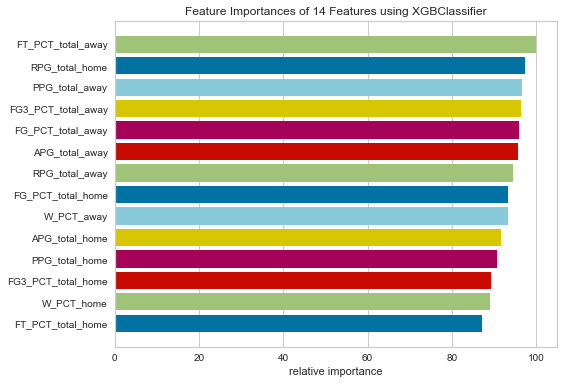

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.46      0.36      0.40      2073
           1       0.56      0.66      0.61      2557

    accuracy                           0.53      4630
   macro avg       0.51      0.51      0.50      4630
weighted avg       0.52      0.53      0.52      4630



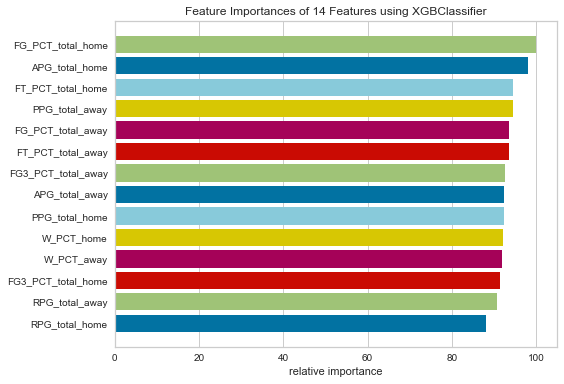

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.33      0.38      2064
           1       0.55      0.67      0.61      2565

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.51      0.52      0.50      4629



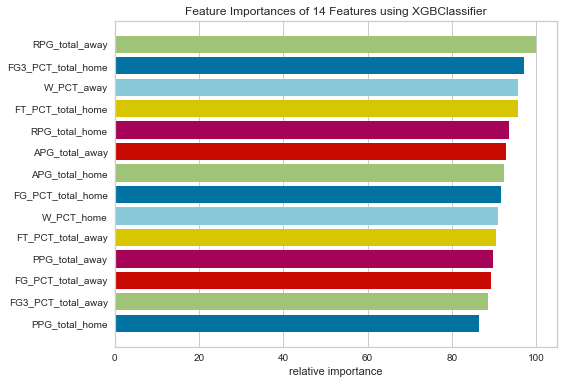

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.35      0.39      2073
           1       0.55      0.66      0.60      2556

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.51      0.52      0.51      4629



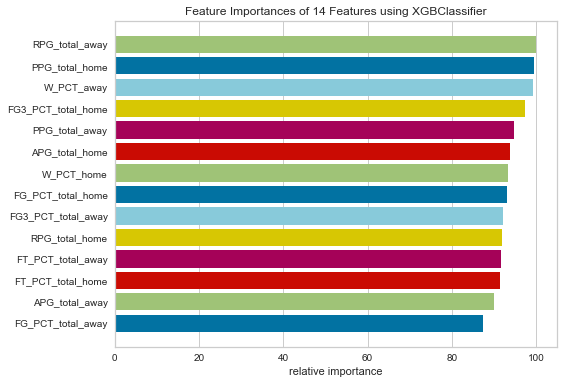

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.34      0.39      2079
           1       0.55      0.67      0.60      2550

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.51      0.52      0.51      4629



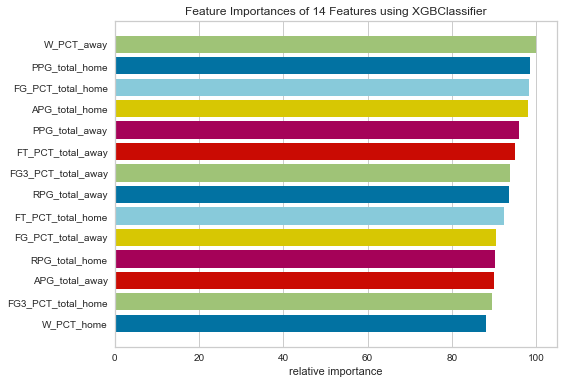

---------------------------------------------
Mean accuracy: 0.5194944235958208
Max accuracy: 0.5259179265658748
Min accuracy: 0.5153347732181426
i=25
REB:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.46      0.39      0.42      2140
           1       0.54      0.61      0.57      2490

    accuracy                           0.51      4630
   macro avg       0.50      0.50      0.49      4630
weighted avg       0.50      0.51      0.50      4630



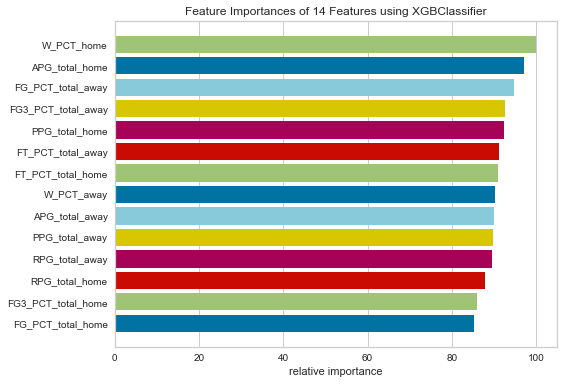

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.47      0.39      0.43      2144
           1       0.54      0.63      0.58      2486

    accuracy                           0.52      4630
   macro avg       0.51      0.51      0.50      4630
weighted avg       0.51      0.52      0.51      4630



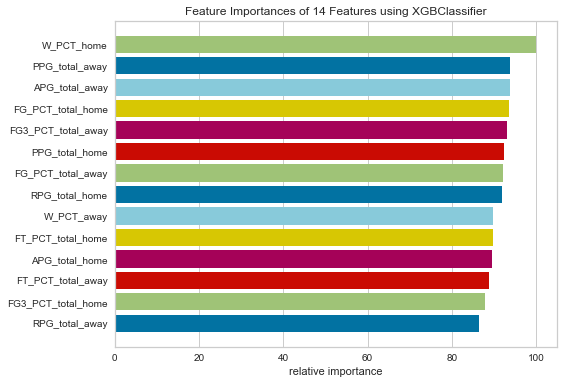

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.47      0.39      0.43      2154
           1       0.54      0.63      0.58      2475

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.50      4629
weighted avg       0.51      0.51      0.51      4629



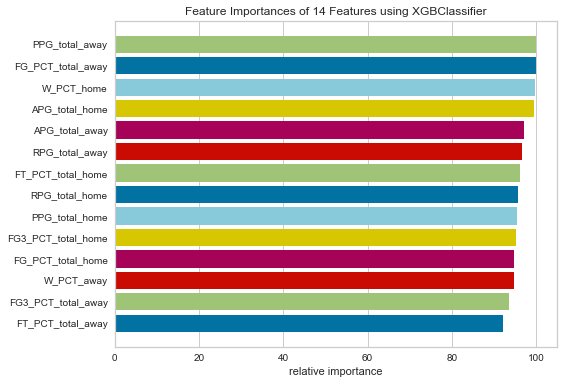

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.47      0.38      0.42      2156
           1       0.53      0.62      0.57      2473

    accuracy                           0.51      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.51      0.50      4629



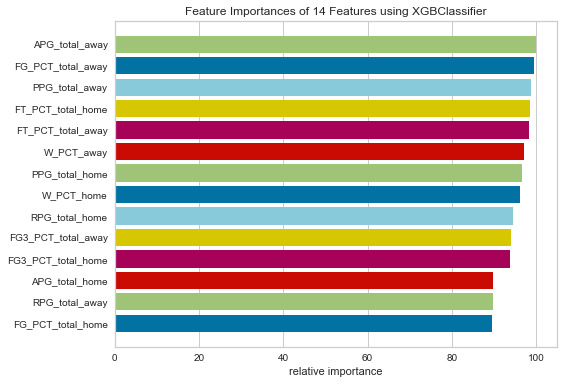

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.47      0.37      0.42      2192
           1       0.53      0.62      0.57      2437

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.50      0.50      0.50      4629



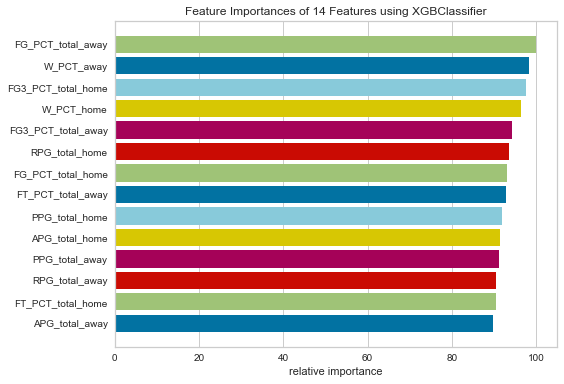

---------------------------------------------
Mean accuracy: 0.5116643500665119
Max accuracy: 0.5168466522678186
Min accuracy: 0.5060475161987041


In [39]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {})

## Try prune max depth

i=0
WINNER:

Best XGBoost accuracy ({'max_depth': 7}): 0.53
              precision    recall  f1-score   support

           0       0.40      0.23      0.29      1953
           1       0.57      0.75      0.65      2677

    accuracy                           0.53      4630
   macro avg       0.49      0.49      0.47      4630
weighted avg       0.50      0.53      0.50      4630



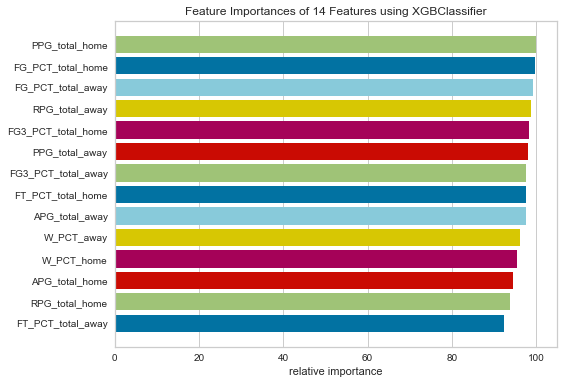

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'max_depth': 4}): 0.57
              precision    recall  f1-score   support

           0       0.39      0.14      0.20      1865
           1       0.59      0.85      0.70      2765

    accuracy                           0.57      4630
   macro avg       0.49      0.50      0.45      4630
weighted avg       0.51      0.57      0.50      4630



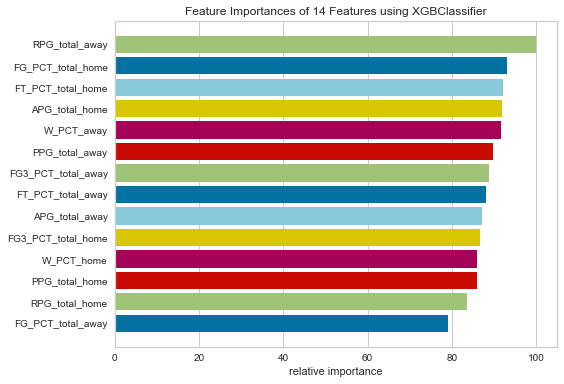

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'max_depth': 24}): 0.55
              precision    recall  f1-score   support

           0       0.40      0.28      0.33      1836
           1       0.60      0.72      0.66      2793

    accuracy                           0.55      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.52      0.55      0.53      4629



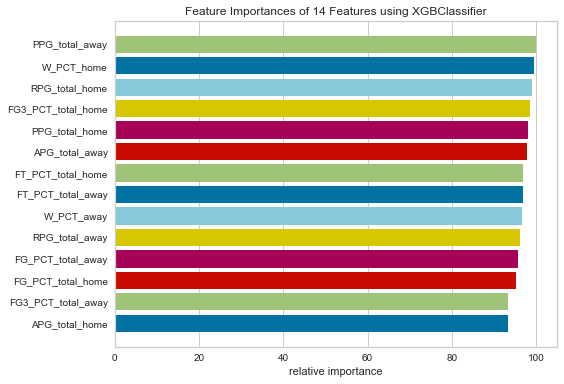

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'max_depth': 3}): 0.59
              precision    recall  f1-score   support

           0       0.43      0.08      0.14      1871
           1       0.60      0.93      0.73      2758

    accuracy                           0.59      4629
   macro avg       0.52      0.50      0.43      4629
weighted avg       0.53      0.59      0.49      4629



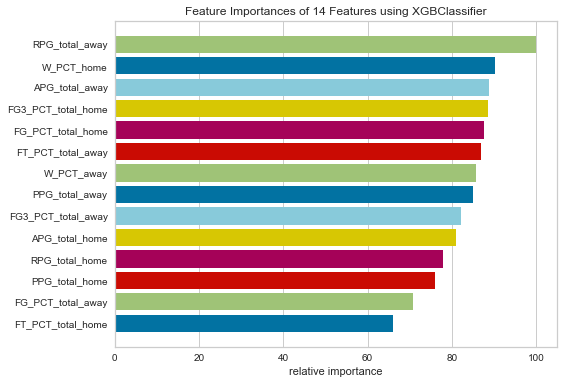

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'max_depth': 3}): 0.57
              precision    recall  f1-score   support

           0       0.41      0.08      0.13      1913
           1       0.59      0.93      0.72      2716

    accuracy                           0.57      4629
   macro avg       0.50      0.50      0.42      4629
weighted avg       0.52      0.57      0.47      4629



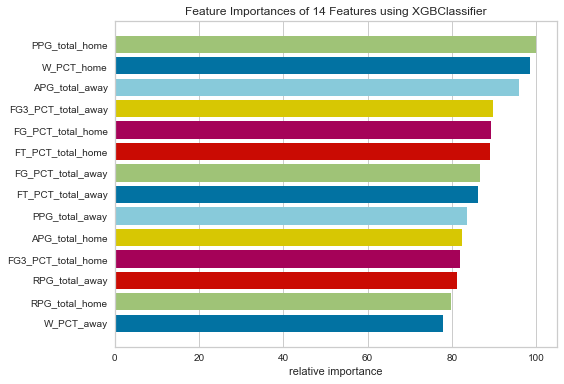

---------------------------------------------
Mean accuracy: 0.5572965672791543
Max accuracy: 0.5854396197882912
Min accuracy: 0.531317494600432
i=5
FGP:

Best XGBoost accuracy ({'max_depth': 5}): 0.52
              precision    recall  f1-score   support

           0       0.46      0.27      0.34      2122
           1       0.54      0.74      0.62      2508

    accuracy                           0.52      4630
   macro avg       0.50      0.50      0.48      4630
weighted avg       0.50      0.52      0.49      4630



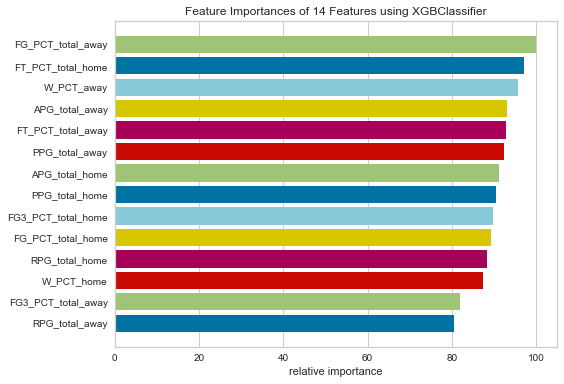

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'max_depth': 3}): 0.53
              precision    recall  f1-score   support

           0       0.44      0.16      0.23      2071
           1       0.55      0.84      0.66      2559

    accuracy                           0.53      4630
   macro avg       0.49      0.50      0.45      4630
weighted avg       0.50      0.53      0.47      4630



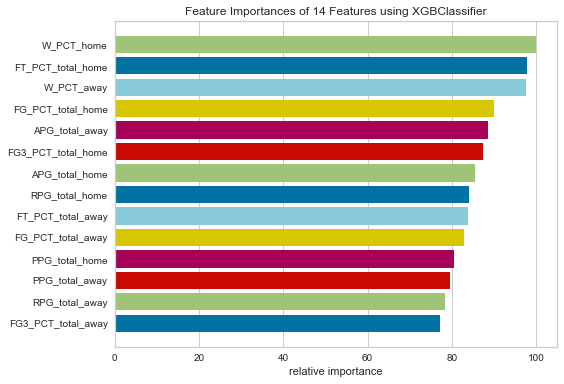

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'max_depth': 5}): 0.53
              precision    recall  f1-score   support

           0       0.46      0.30      0.37      2082
           1       0.55      0.71      0.62      2547

    accuracy                           0.53      4629
   macro avg       0.51      0.51      0.49      4629
weighted avg       0.51      0.53      0.51      4629



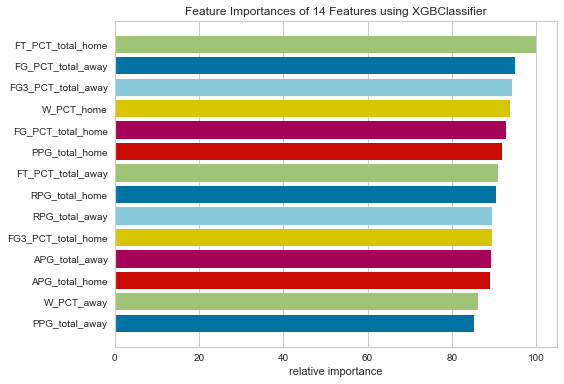

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'max_depth': 3}): 0.55
              precision    recall  f1-score   support

           0       0.47      0.19      0.28      2041
           1       0.57      0.83      0.67      2588

    accuracy                           0.55      4629
   macro avg       0.52      0.51      0.47      4629
weighted avg       0.53      0.55      0.50      4629



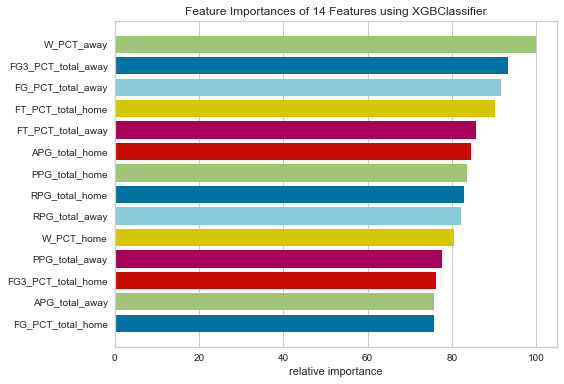

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'max_depth': 3}): 0.54
              precision    recall  f1-score   support

           0       0.45      0.18      0.26      2060
           1       0.56      0.82      0.66      2569

    accuracy                           0.54      4629
   macro avg       0.50      0.50      0.46      4629
weighted avg       0.51      0.54      0.48      4629



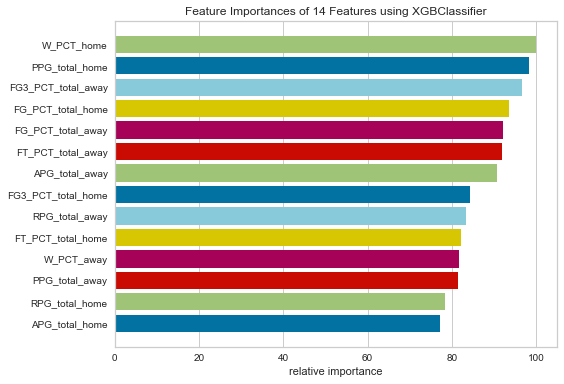

---------------------------------------------
Mean accuracy: 0.5319694903992904
Max accuracy: 0.5495787427090084
Min accuracy: 0.5205183585313174
i=10
FG3:

Best XGBoost accuracy ({'max_depth': 5}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.46      0.47      2266
           1       0.51      0.54      0.53      2364

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



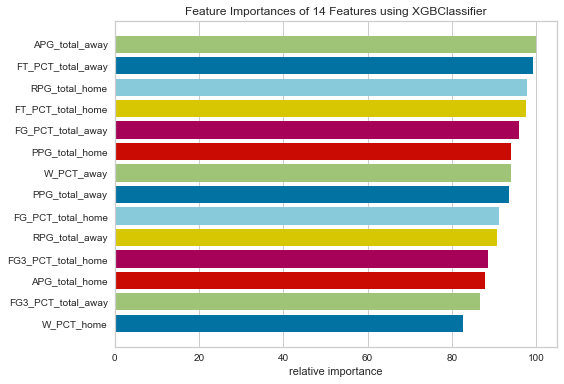

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'max_depth': 16}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2292
           1       0.50      0.52      0.51      2338

    accuracy                           0.49      4630
   macro avg       0.49      0.49      0.49      4630
weighted avg       0.49      0.49      0.49      4630



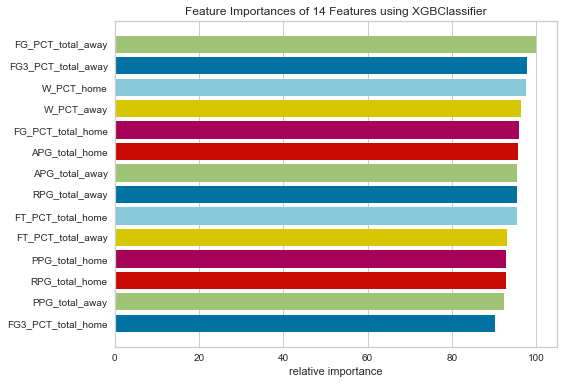

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'max_depth': 5}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2223
           1       0.53      0.54      0.53      2406

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



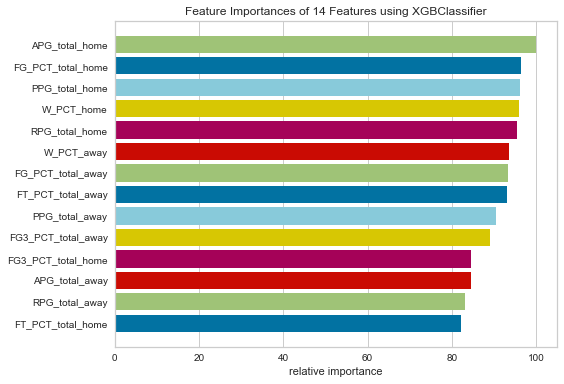

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'max_depth': 7}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2265
           1       0.52      0.53      0.53      2364

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



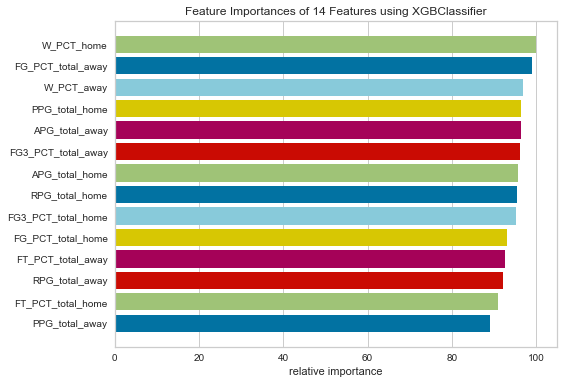

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'max_depth': 3}): 0.48
              precision    recall  f1-score   support

           0       0.48      0.41      0.44      2324
           1       0.48      0.56      0.52      2305

    accuracy                           0.48      4629
   macro avg       0.48      0.48      0.48      4629
weighted avg       0.48      0.48      0.48      4629



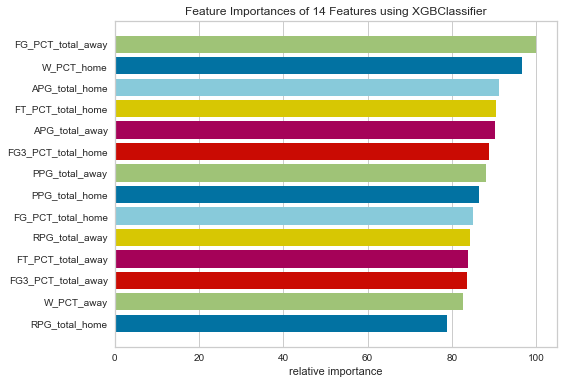

---------------------------------------------
Mean accuracy: 0.502754747863852
Max accuracy: 0.5106934543097861
Min accuracy: 0.49352051835853133
i=15
FT:

Best XGBoost accuracy ({'max_depth': 10}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2350
           1       0.49      0.49      0.49      2280

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



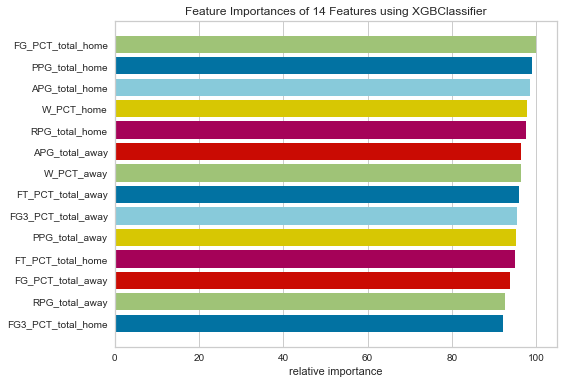

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'max_depth': 14}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2324
           1       0.50      0.48      0.49      2306

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



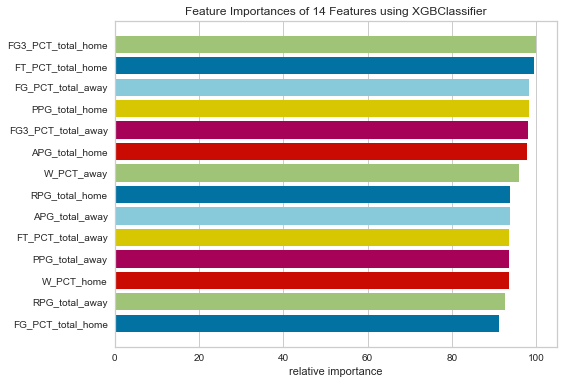

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'max_depth': 15}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      2309
           1       0.50      0.47      0.49      2320

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



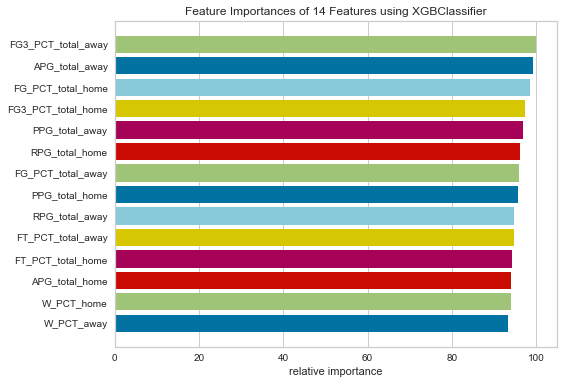

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'max_depth': 23}): 0.51
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      2390
           1       0.49      0.52      0.50      2239

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



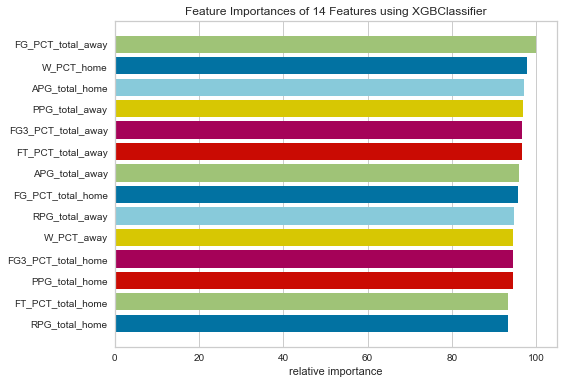

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'max_depth': 19}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      2332
           1       0.50      0.48      0.49      2297

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



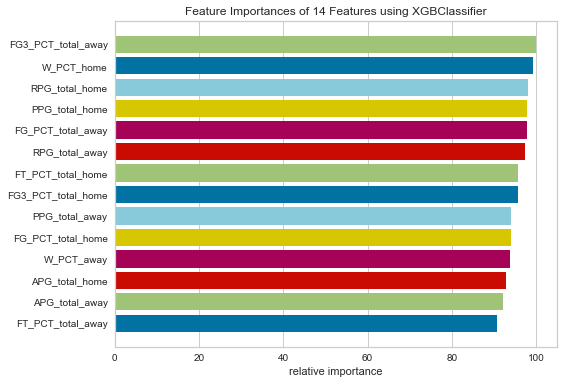

---------------------------------------------
Mean accuracy: 0.502916373300635
Max accuracy: 0.509397278029812
Min accuracy: 0.49870410367170626
i=20
AST:

Best XGBoost accuracy ({'max_depth': 3}): 0.53
              precision    recall  f1-score   support

           0       0.47      0.17      0.25      2120
           1       0.55      0.84      0.66      2510

    accuracy                           0.53      4630
   macro avg       0.51      0.50      0.46      4630
weighted avg       0.51      0.53      0.47      4630



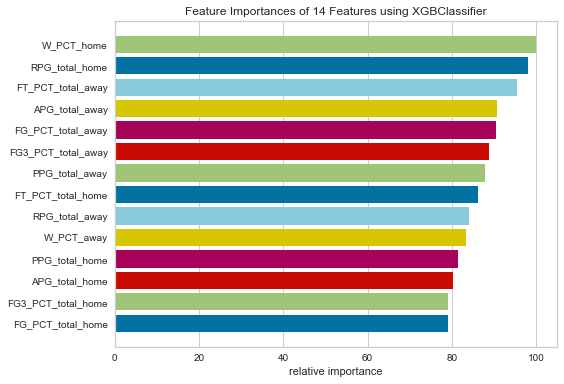

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'max_depth': 3}): 0.53
              precision    recall  f1-score   support

           0       0.43      0.18      0.26      2073
           1       0.55      0.81      0.65      2557

    accuracy                           0.53      4630
   macro avg       0.49      0.49      0.46      4630
weighted avg       0.50      0.53      0.48      4630



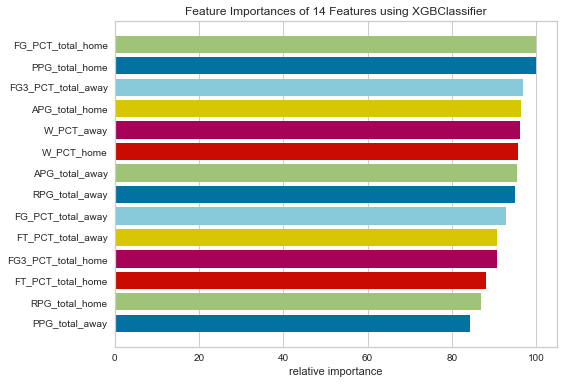

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'max_depth': 3}): 0.54
              precision    recall  f1-score   support

           0       0.46      0.20      0.27      2064
           1       0.56      0.81      0.66      2565

    accuracy                           0.54      4629
   macro avg       0.51      0.50      0.47      4629
weighted avg       0.51      0.54      0.49      4629



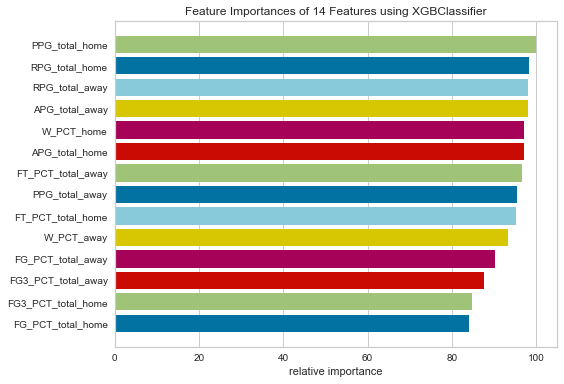

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'max_depth': 5}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.30      0.36      2073
           1       0.55      0.70      0.62      2556

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.51      0.52      0.50      4629



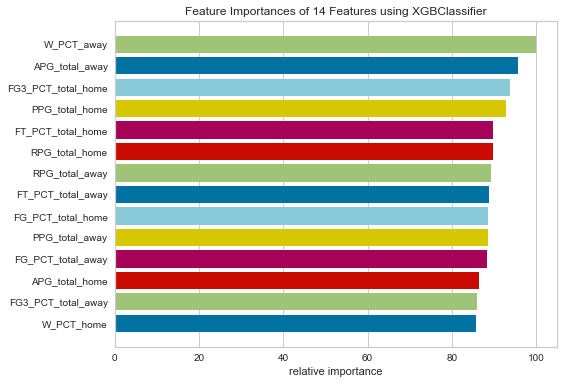

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'max_depth': 3}): 0.53
              precision    recall  f1-score   support

           0       0.43      0.18      0.26      2079
           1       0.55      0.81      0.65      2550

    accuracy                           0.53      4629
   macro avg       0.49      0.49      0.45      4629
weighted avg       0.50      0.53      0.47      4629



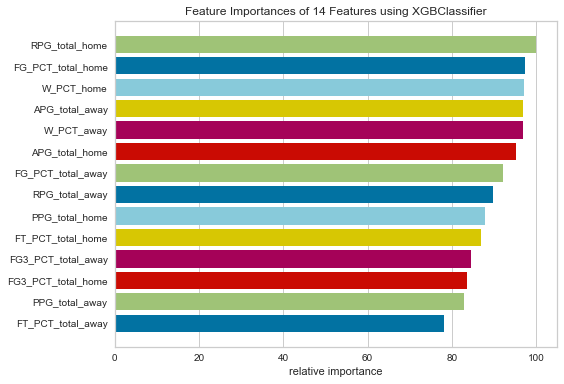

---------------------------------------------
Mean accuracy: 0.5299708337007699
Max accuracy: 0.5372650680492547
Min accuracy: 0.5225750702095485
i=25
REB:

Best XGBoost accuracy ({'max_depth': 3}): 0.51
              precision    recall  f1-score   support

           0       0.45      0.25      0.32      2140
           1       0.53      0.74      0.62      2490

    accuracy                           0.51      4630
   macro avg       0.49      0.49      0.47      4630
weighted avg       0.50      0.51      0.48      4630



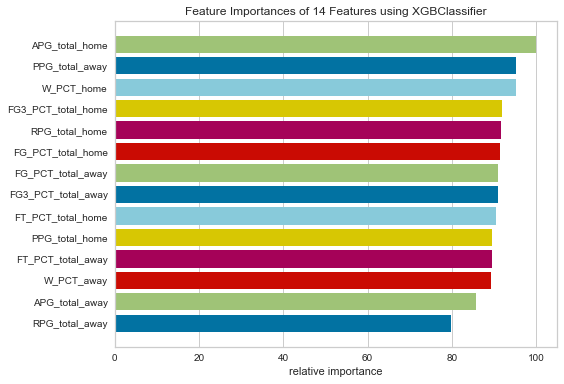

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'max_depth': 28}): 0.50
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      2144
           1       0.53      0.57      0.55      2486

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



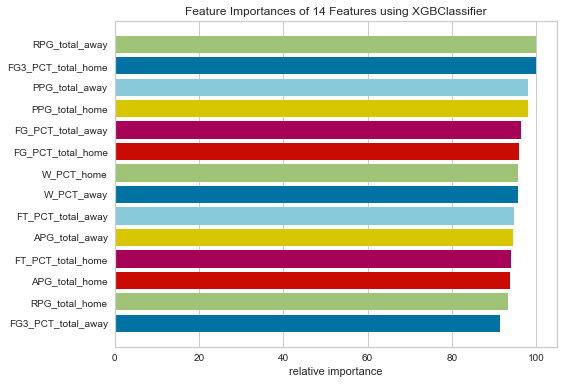

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'max_depth': 8}): 0.50
              precision    recall  f1-score   support

           0       0.46      0.41      0.44      2154
           1       0.53      0.58      0.56      2475

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



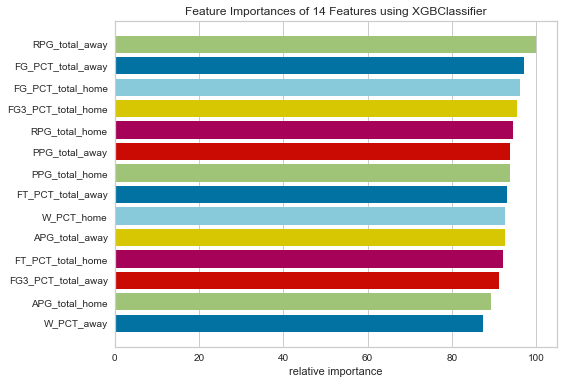

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'max_depth': 7}): 0.51
              precision    recall  f1-score   support

           0       0.47      0.41      0.44      2156
           1       0.54      0.60      0.57      2473

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



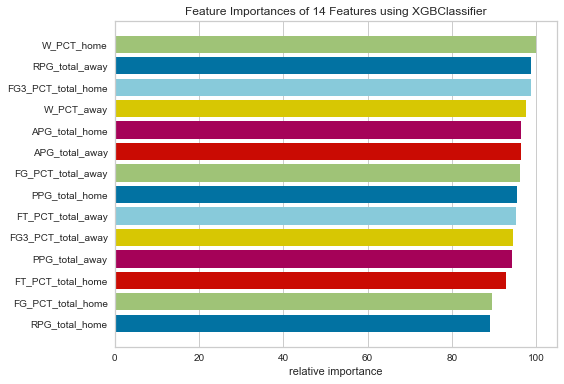

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'max_depth': 3}): 0.51
              precision    recall  f1-score   support

           0       0.46      0.23      0.30      2192
           1       0.52      0.76      0.62      2437

    accuracy                           0.51      4629
   macro avg       0.49      0.49      0.46      4629
weighted avg       0.49      0.51      0.47      4629



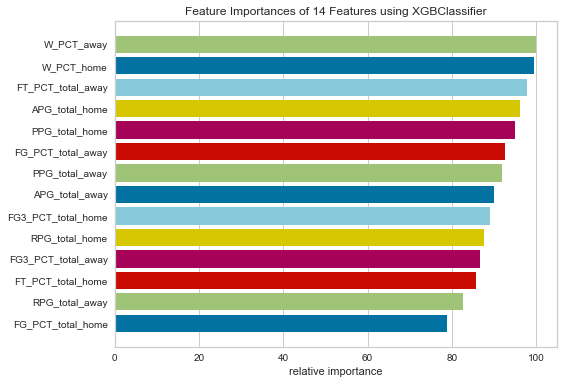

---------------------------------------------
Mean accuracy: 0.5084783249744428
Max accuracy: 0.5139338950097213
Min accuracy: 0.5030237580993521


In [42]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(3,30)],
})

## Try prune reg_lambda

i=0
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.53
              precision    recall  f1-score   support

           0       0.39      0.20      0.26      1953
           1       0.57      0.78      0.66      2677

    accuracy                           0.53      4630
   macro avg       0.48      0.49      0.46      4630
weighted avg       0.50      0.53      0.49      4630



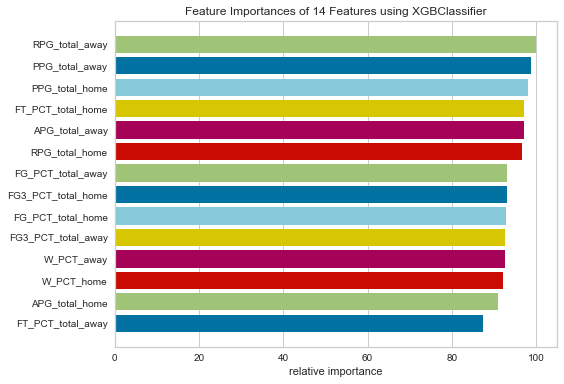

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.54
              precision    recall  f1-score   support

           0       0.39      0.23      0.28      1865
           1       0.59      0.76      0.67      2765

    accuracy                           0.54      4630
   macro avg       0.49      0.49      0.48      4630
weighted avg       0.51      0.54      0.51      4630



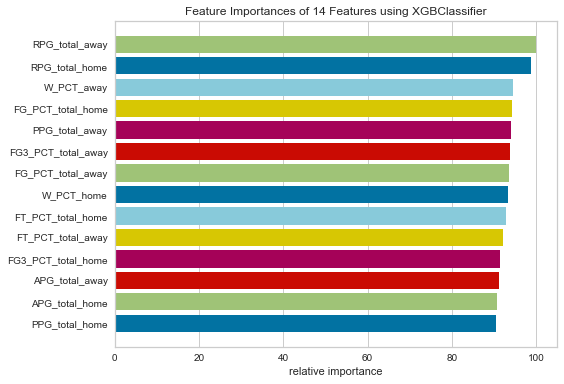

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.95}): 0.55
              precision    recall  f1-score   support

           0       0.37      0.21      0.27      1836
           1       0.60      0.77      0.67      2793

    accuracy                           0.55      4629
   macro avg       0.48      0.49      0.47      4629
weighted avg       0.51      0.55      0.51      4629



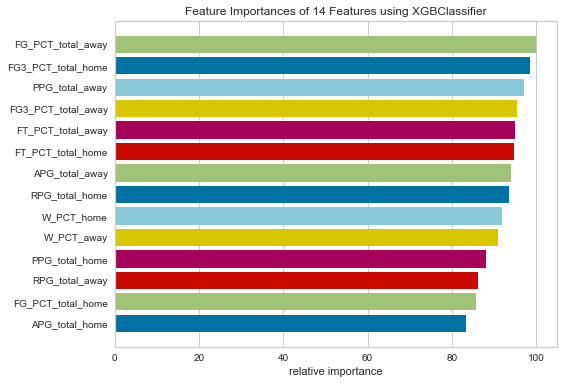

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.54
              precision    recall  f1-score   support

           0       0.39      0.22      0.28      1871
           1       0.59      0.77      0.67      2758

    accuracy                           0.54      4629
   macro avg       0.49      0.49      0.47      4629
weighted avg       0.51      0.54      0.51      4629



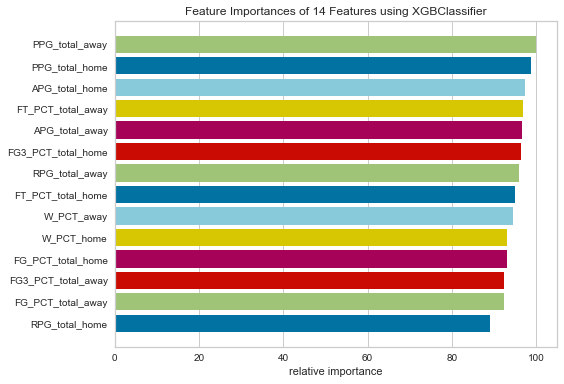

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.35}): 0.55
              precision    recall  f1-score   support

           0       0.41      0.22      0.29      1913
           1       0.59      0.78      0.67      2716

    accuracy                           0.55      4629
   macro avg       0.50      0.50      0.48      4629
weighted avg       0.52      0.55      0.51      4629



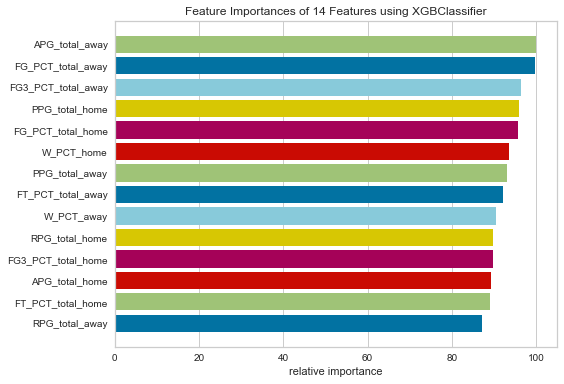

---------------------------------------------
Mean accuracy: 0.5420675458082601
Max accuracy: 0.5461222726290775
Min accuracy: 0.5332613390928725
i=5
FGP:

Best XGBoost accuracy ({'reg_lambda': 1}): 0.51
              precision    recall  f1-score   support

           0       0.45      0.31      0.36      2122
           1       0.54      0.68      0.60      2508

    accuracy                           0.51      4630
   macro avg       0.49      0.49      0.48      4630
weighted avg       0.50      0.51      0.49      4630



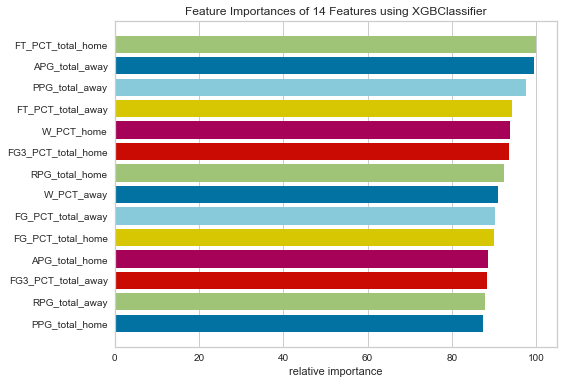

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.9}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.33      0.38      2071
           1       0.55      0.67      0.61      2559

    accuracy                           0.52      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.51      0.52      0.51      4630



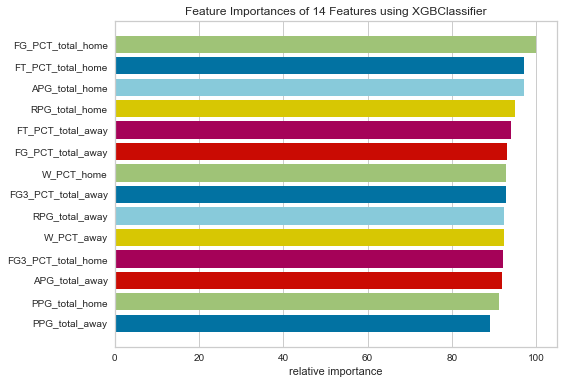

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.9}): 0.52
              precision    recall  f1-score   support

           0       0.46      0.33      0.38      2082
           1       0.55      0.68      0.61      2547

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.51      0.52      0.51      4629



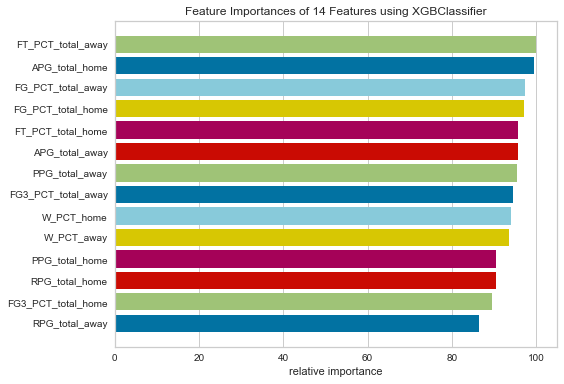

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.4}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.34      0.39      2041
           1       0.56      0.67      0.61      2588

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.51      0.52      0.51      4629



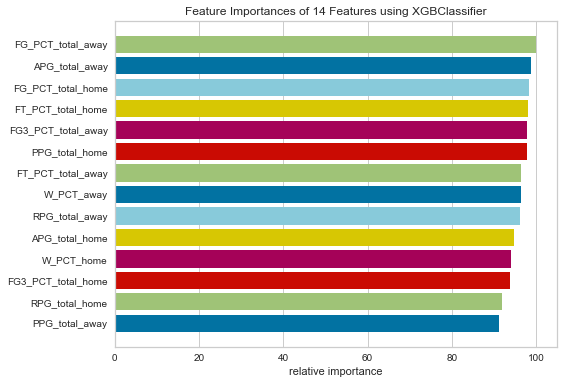

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.95}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.32      0.37      2060
           1       0.56      0.68      0.61      2569

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.51      0.52      0.51      4629



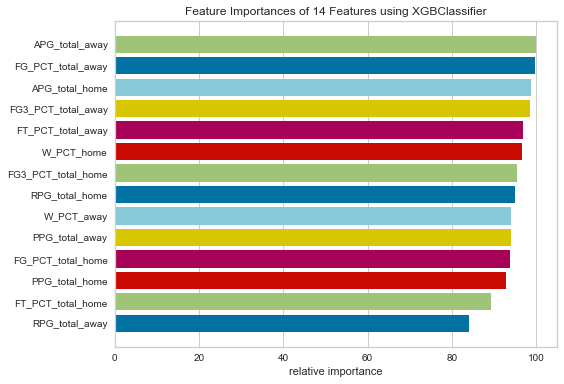

---------------------------------------------
Mean accuracy: 0.518684954976771
Max accuracy: 0.5234391877295312
Min accuracy: 0.5086393088552916
i=10
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.45      0.47      2266
           1       0.51      0.55      0.53      2364

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



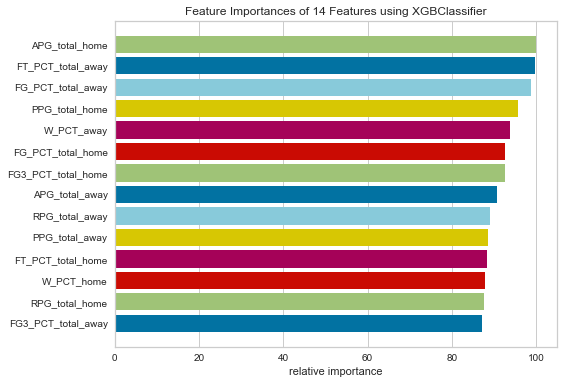

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.8}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2292
           1       0.51      0.53      0.52      2338

    accuracy                           0.51      4630
   macro avg       0.51      0.51      0.51      4630
weighted avg       0.51      0.51      0.51      4630



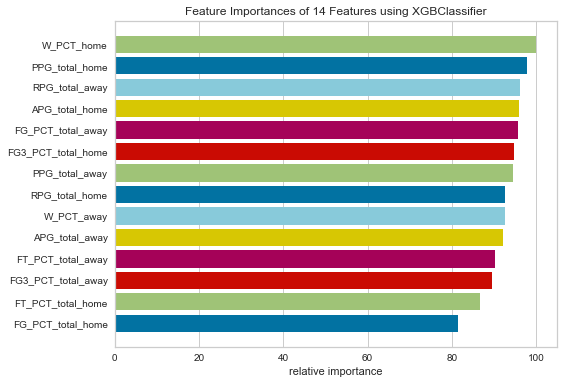

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.95}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.47      0.47      2223
           1       0.52      0.53      0.52      2406

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



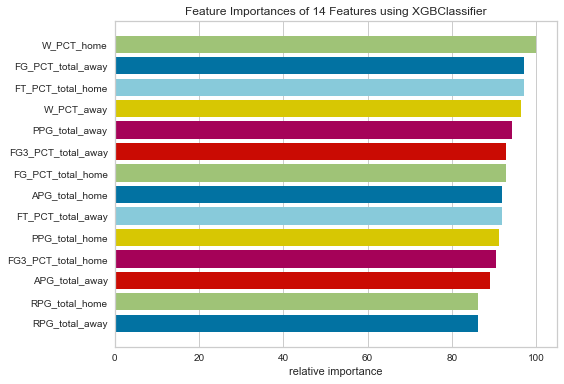

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2265
           1       0.51      0.53      0.52      2364

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



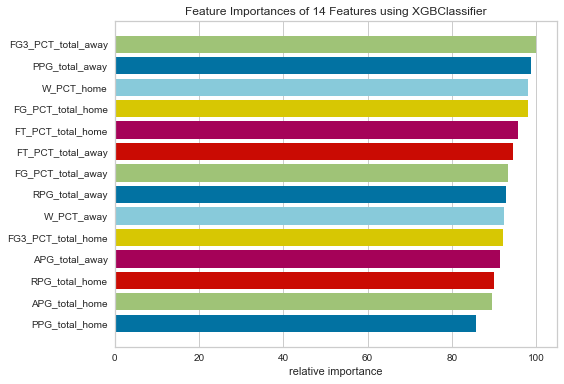

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      2324
           1       0.50      0.54      0.52      2305

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



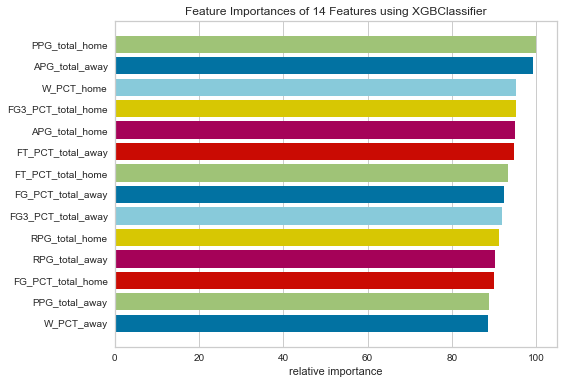

---------------------------------------------
Mean accuracy: 0.5024838712838164
Max accuracy: 0.5069114470842333
Min accuracy: 0.4983797796500324
i=15
FT:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2350
           1       0.49      0.48      0.49      2280

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



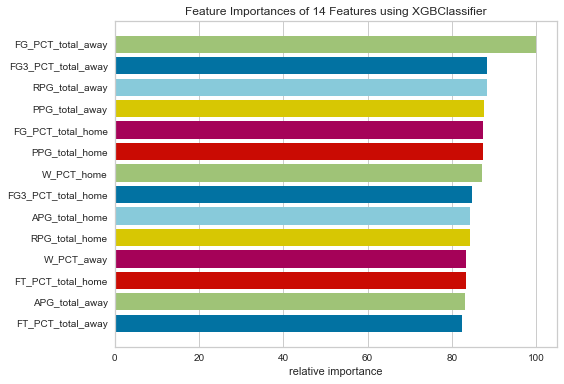

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'reg_lambda': 0.6}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2324
           1       0.49      0.47      0.48      2306

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



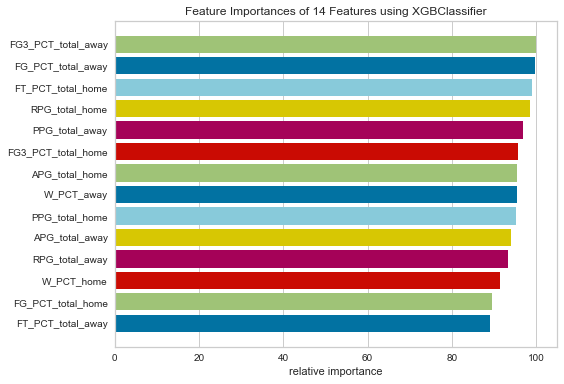

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.54      0.52      2309
           1       0.50      0.45      0.47      2320

    accuracy                           0.49      4629
   macro avg       0.49      0.49      0.49      4629
weighted avg       0.49      0.49      0.49      4629



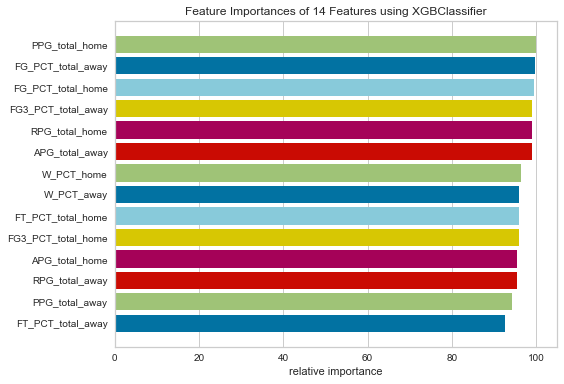

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.51
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2390
           1       0.49      0.51      0.50      2239

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



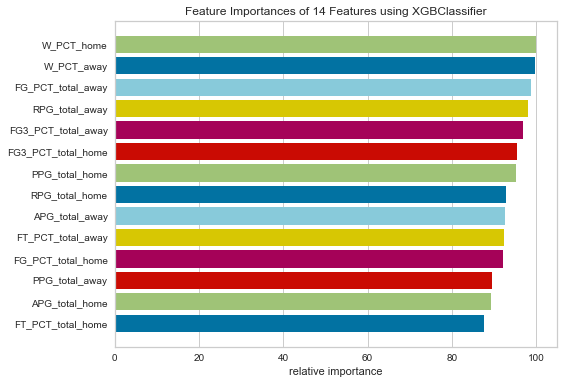

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'reg_lambda': 0.8}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2332
           1       0.52      0.50      0.51      2297

    accuracy                           0.52      4629
   macro avg       0.52      0.52      0.52      4629
weighted avg       0.52      0.52      0.52      4629



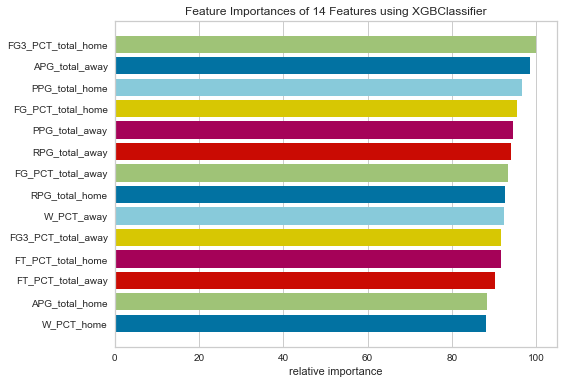

---------------------------------------------
Mean accuracy: 0.5002162393437559
Max accuracy: 0.5100453661697991
Min accuracy: 0.49470728019010585
i=20
AST:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.52
              precision    recall  f1-score   support

           0       0.47      0.32      0.38      2120
           1       0.55      0.68      0.61      2510

    accuracy                           0.52      4630
   macro avg       0.51      0.50      0.49      4630
weighted avg       0.51      0.52      0.50      4630



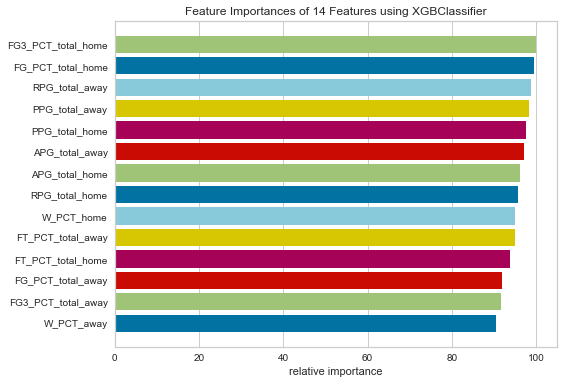

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.33      0.38      2073
           1       0.55      0.67      0.61      2557

    accuracy                           0.52      4630
   macro avg       0.50      0.50      0.49      4630
weighted avg       0.51      0.52      0.51      4630



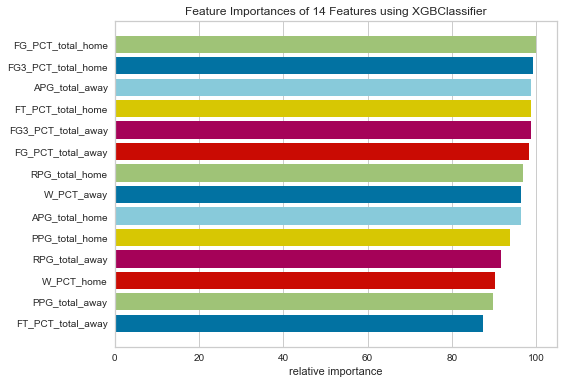

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.52
              precision    recall  f1-score   support

           0       0.46      0.37      0.41      2064
           1       0.56      0.65      0.60      2565

    accuracy                           0.52      4629
   macro avg       0.51      0.51      0.50      4629
weighted avg       0.51      0.52      0.52      4629



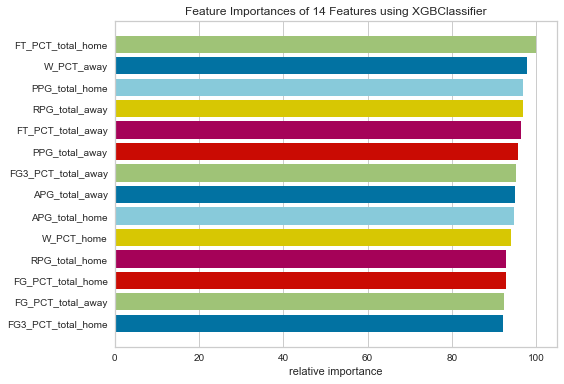

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'reg_lambda': 0.85}): 0.52
              precision    recall  f1-score   support

           0       0.45      0.34      0.39      2073
           1       0.56      0.67      0.61      2556

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.51      0.52      0.51      4629



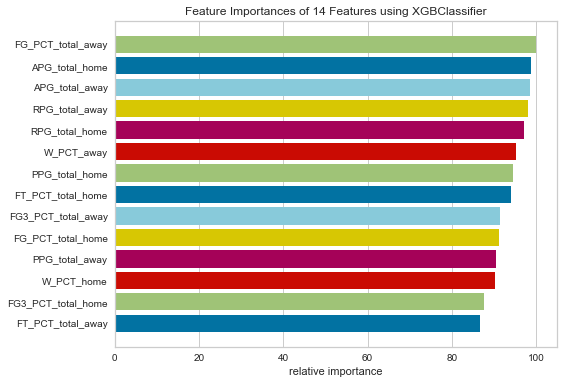

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.53
              precision    recall  f1-score   support

           0       0.47      0.34      0.40      2079
           1       0.56      0.69      0.62      2550

    accuracy                           0.53      4629
   macro avg       0.52      0.51      0.51      4629
weighted avg       0.52      0.53      0.52      4629



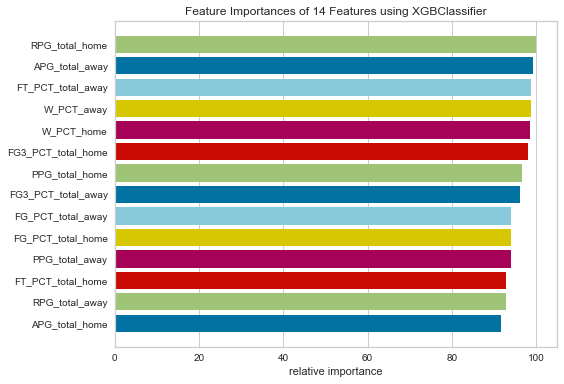

---------------------------------------------
Mean accuracy: 0.520790774845595
Max accuracy: 0.5238712464895225
Min accuracy: 0.5181425485961123
i=25
REB:

Best XGBoost accuracy ({'reg_lambda': 0.8}): 0.52
              precision    recall  f1-score   support

           0       0.47      0.39      0.43      2140
           1       0.55      0.62      0.58      2490

    accuracy                           0.52      4630
   macro avg       0.51      0.51      0.51      4630
weighted avg       0.51      0.52      0.51      4630



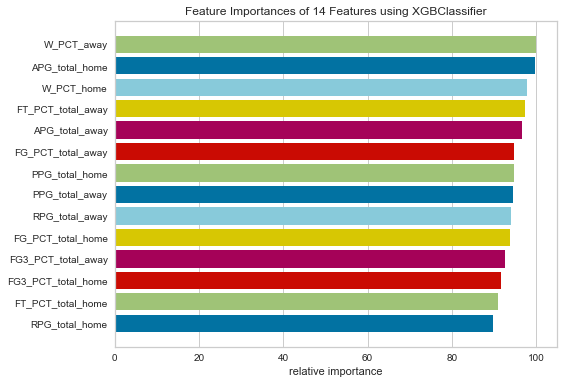

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.51
              precision    recall  f1-score   support

           0       0.46      0.38      0.42      2144
           1       0.54      0.62      0.58      2486

    accuracy                           0.51      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.51      0.50      4630



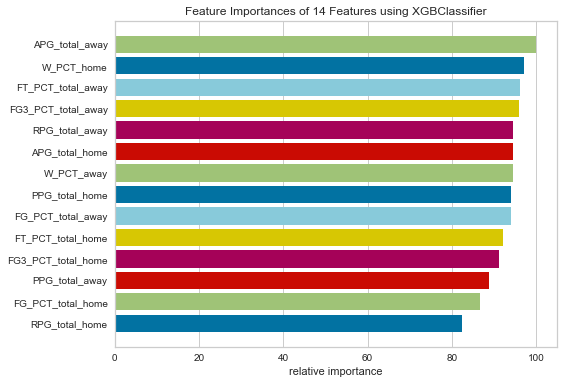

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'reg_lambda': 0.9}): 0.50
              precision    recall  f1-score   support

           0       0.46      0.39      0.42      2154
           1       0.53      0.61      0.57      2475

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.50      0.50      0.50      4629



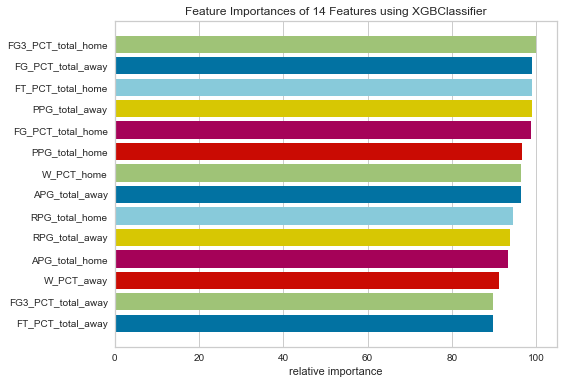

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.51
              precision    recall  f1-score   support

           0       0.46      0.38      0.42      2156
           1       0.53      0.62      0.57      2473

    accuracy                           0.51      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.50      0.51      0.50      4629



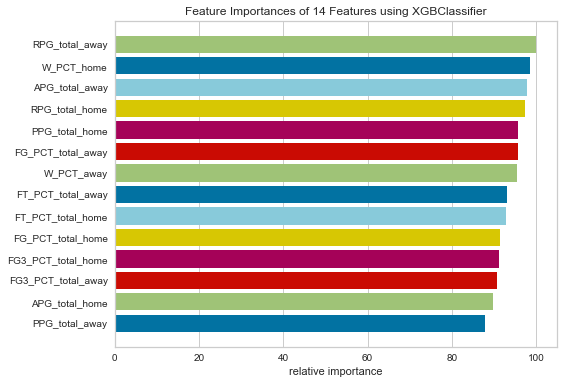

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.50
              precision    recall  f1-score   support

           0       0.47      0.37      0.41      2192
           1       0.52      0.61      0.56      2437

    accuracy                           0.50      4629
   macro avg       0.49      0.49      0.49      4629
weighted avg       0.49      0.50      0.49      4629



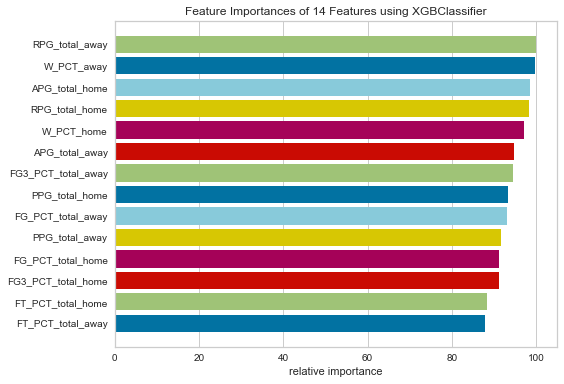

---------------------------------------------
Mean accuracy: 0.5099358467395194
Max accuracy: 0.5185745140388769
Min accuracy: 0.5048606610499028


In [43]:
# L2 regularization term on weights. Increasing this value will make model more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'reg_lambda': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
})

## Try prune learning rate

i=0
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.15}): 0.56
              precision    recall  f1-score   support

           0       0.42      0.12      0.18      1953
           1       0.58      0.88      0.70      2677

    accuracy                           0.56      4630
   macro avg       0.50      0.50      0.44      4630
weighted avg       0.51      0.56      0.48      4630



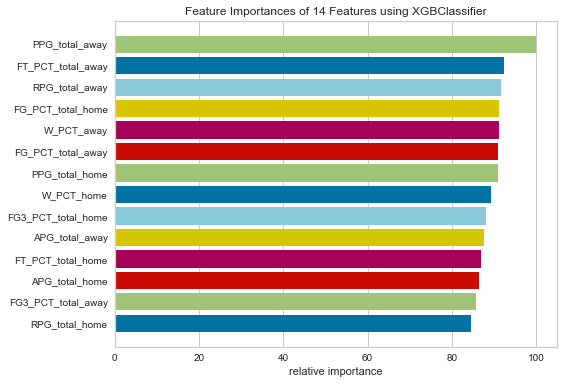

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.1}): 0.58
              precision    recall  f1-score   support

           0       0.39      0.08      0.13      1865
           1       0.60      0.92      0.72      2765

    accuracy                           0.58      4630
   macro avg       0.49      0.50      0.43      4630
weighted avg       0.51      0.58      0.48      4630



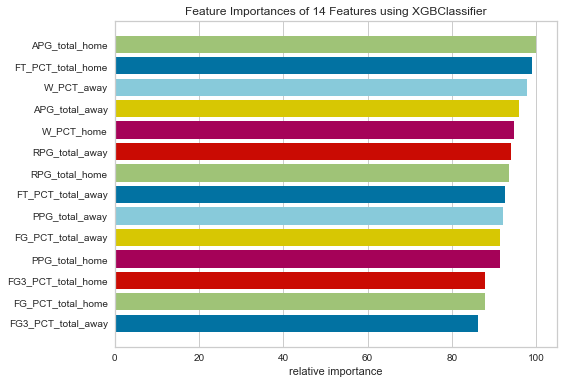

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.59
              precision    recall  f1-score   support

           0       0.38      0.04      0.07      1836
           1       0.60      0.96      0.74      2793

    accuracy                           0.59      4629
   macro avg       0.49      0.50      0.40      4629
weighted avg       0.52      0.59      0.47      4629



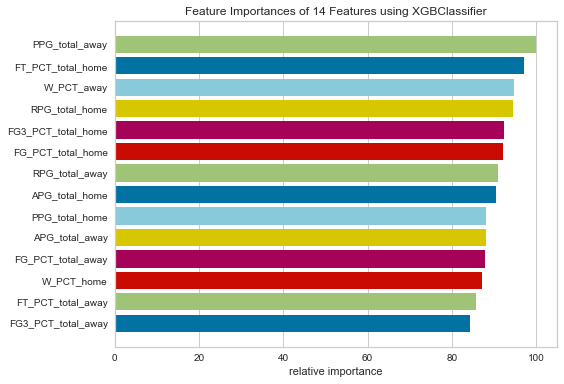

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.59
              precision    recall  f1-score   support

           0       0.44      0.02      0.05      1871
           1       0.60      0.98      0.74      2758

    accuracy                           0.59      4629
   macro avg       0.52      0.50      0.39      4629
weighted avg       0.53      0.59      0.46      4629



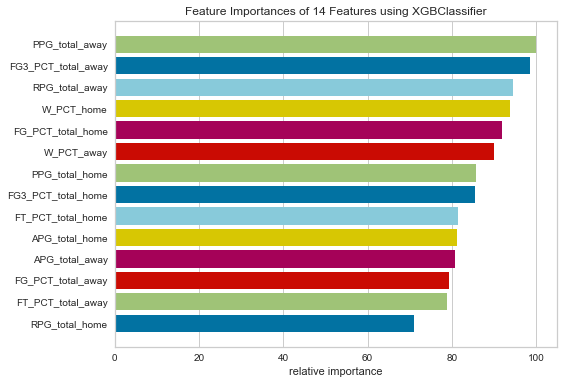

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.58
              precision    recall  f1-score   support

           0       0.44      0.02      0.04      1913
           1       0.59      0.98      0.73      2716

    accuracy                           0.58      4629
   macro avg       0.51      0.50      0.39      4629
weighted avg       0.52      0.58      0.45      4629



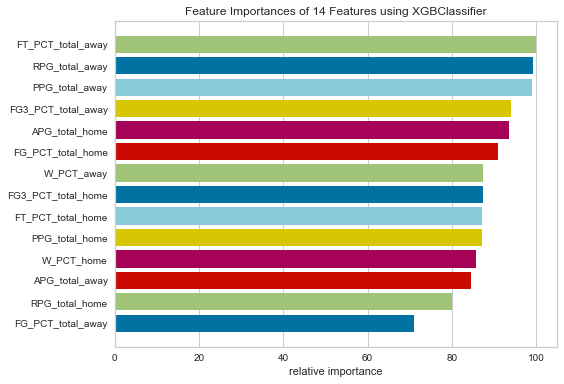

---------------------------------------------
Mean accuracy: 0.5818135689779944
Max accuracy: 0.594296824368114
Min accuracy: 0.5596112311015119
i=5
FGP:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.54
              precision    recall  f1-score   support

           0       0.49      0.08      0.14      2122
           1       0.54      0.93      0.69      2508

    accuracy                           0.54      4630
   macro avg       0.52      0.51      0.42      4630
weighted avg       0.52      0.54      0.44      4630



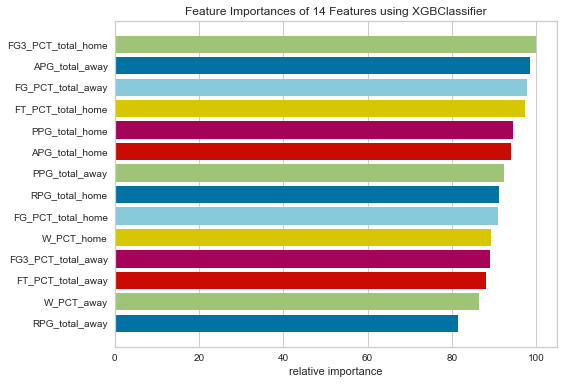

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'learning_rate': 0.1}): 0.53
              precision    recall  f1-score   support

           0       0.43      0.16      0.23      2071
           1       0.55      0.83      0.66      2559

    accuracy                           0.53      4630
   macro avg       0.49      0.50      0.45      4630
weighted avg       0.50      0.53      0.47      4630



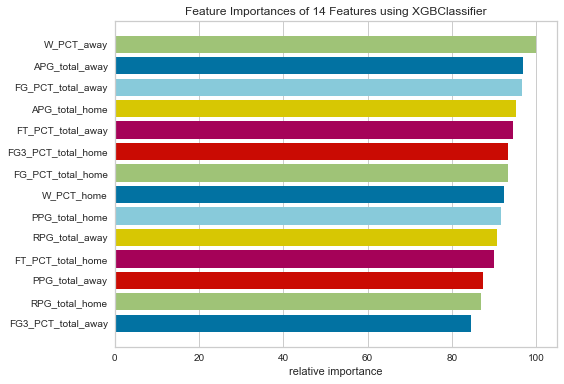

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'learning_rate': 0.2}): 0.53
              precision    recall  f1-score   support

           0       0.46      0.29      0.36      2082
           1       0.55      0.72      0.63      2547

    accuracy                           0.53      4629
   macro avg       0.51      0.51      0.49      4629
weighted avg       0.51      0.53      0.51      4629



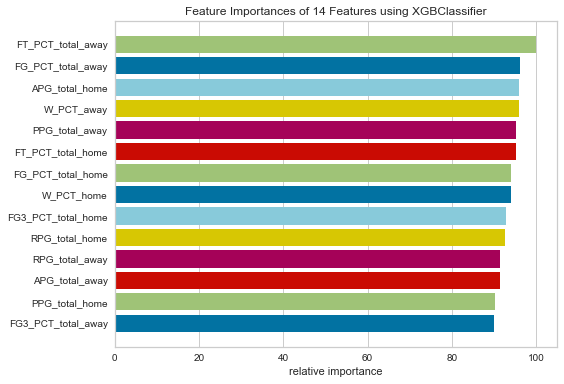

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.56
              precision    recall  f1-score   support

           0       0.58      0.04      0.07      2041
           1       0.56      0.98      0.71      2588

    accuracy                           0.56      4629
   macro avg       0.57      0.51      0.39      4629
weighted avg       0.57      0.56      0.43      4629



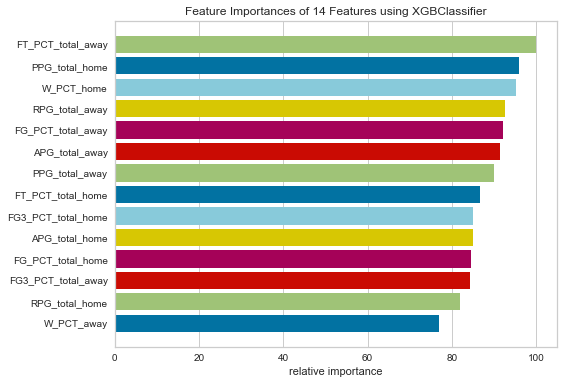

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'learning_rate': 0.1}): 0.53
              precision    recall  f1-score   support

           0       0.44      0.16      0.24      2060
           1       0.55      0.83      0.66      2569

    accuracy                           0.53      4629
   macro avg       0.50      0.50      0.45      4629
weighted avg       0.50      0.53      0.47      4629



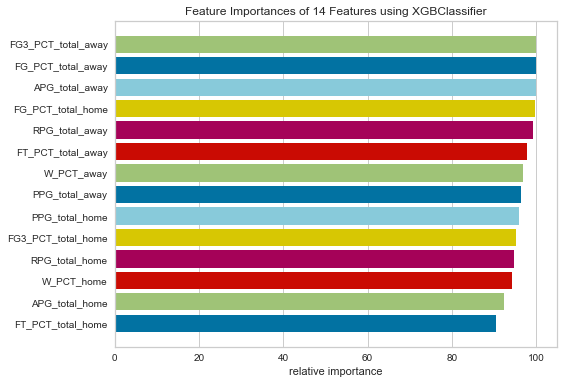

---------------------------------------------
Mean accuracy: 0.5407716728092731
Max accuracy: 0.563404623028732
Min accuracy: 0.5279758047094405
i=10
FG3:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.36      0.41      2266
           1       0.50      0.62      0.56      2364

    accuracy                           0.49      4630
   macro avg       0.49      0.49      0.48      4630
weighted avg       0.49      0.49      0.49      4630



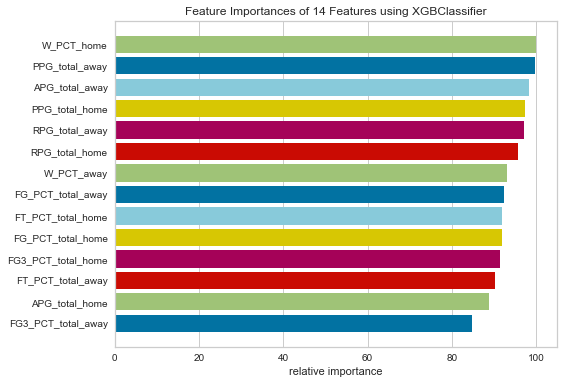

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      2292
           1       0.50      0.63      0.56      2338

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.49      4630
weighted avg       0.50      0.50      0.49      4630



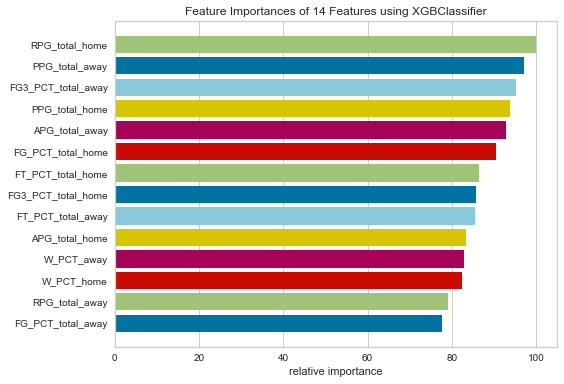

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      2223
           1       0.53      0.52      0.53      2406

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



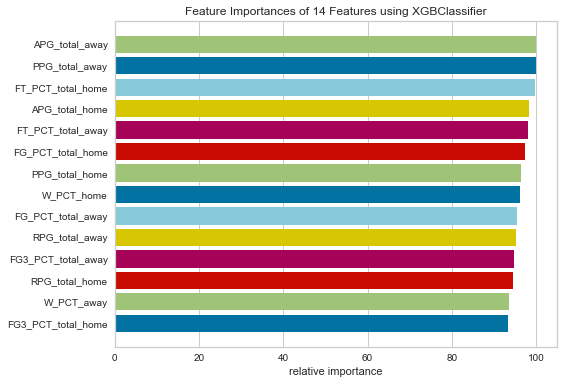

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'learning_rate': 0.45}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2265
           1       0.52      0.52      0.52      2364

    accuracy                           0.51      4629
   macro avg       0.51      0.51      0.51      4629
weighted avg       0.51      0.51      0.51      4629



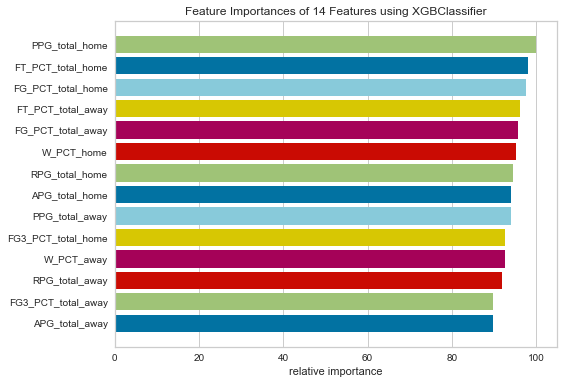

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.35      0.41      2324
           1       0.50      0.64      0.56      2305

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.49      4629
weighted avg       0.50      0.50      0.49      4629



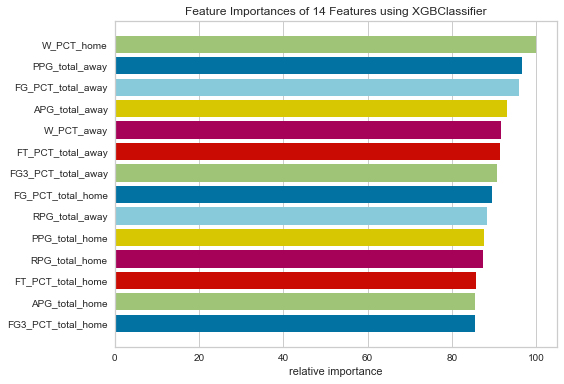

---------------------------------------------
Mean accuracy: 0.5038888787795227
Max accuracy: 0.5111255130697775
Min accuracy: 0.4943844492440605
i=15
FT:

Best XGBoost accuracy ({'learning_rate': 0.35}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2350
           1       0.49      0.48      0.49      2280

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



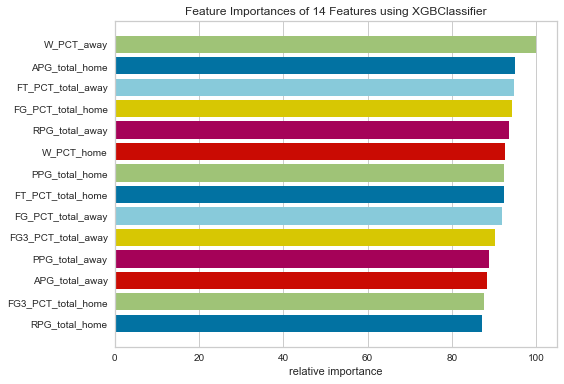

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'learning_rate': 0.6}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2324
           1       0.50      0.49      0.50      2306

    accuracy                           0.51      4630
   macro avg       0.51      0.51      0.51      4630
weighted avg       0.51      0.51      0.51      4630



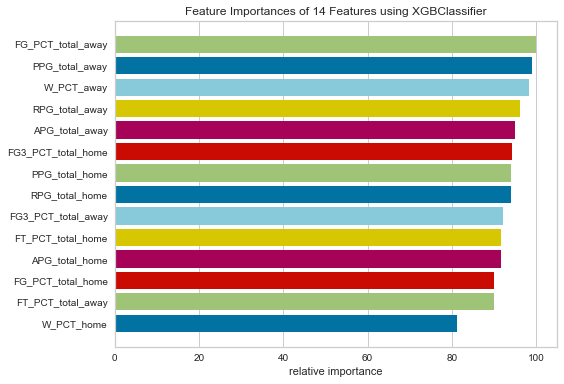

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'learning_rate': 0.45}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2309
           1       0.50      0.49      0.50      2320

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



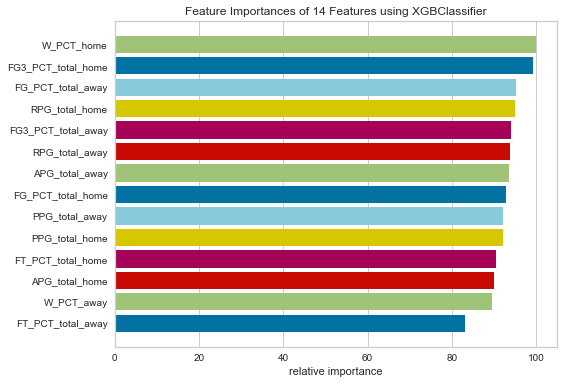

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2390
           1       0.49      0.50      0.50      2239

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



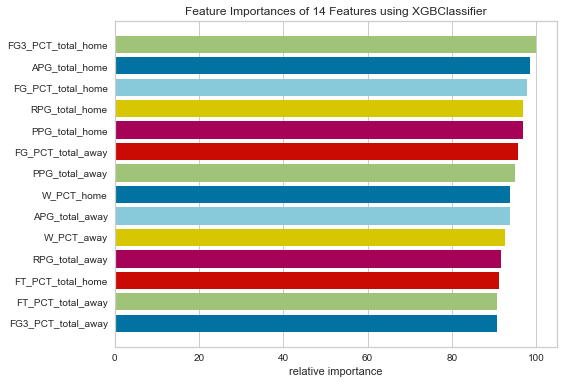

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2332
           1       0.50      0.48      0.49      2297

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



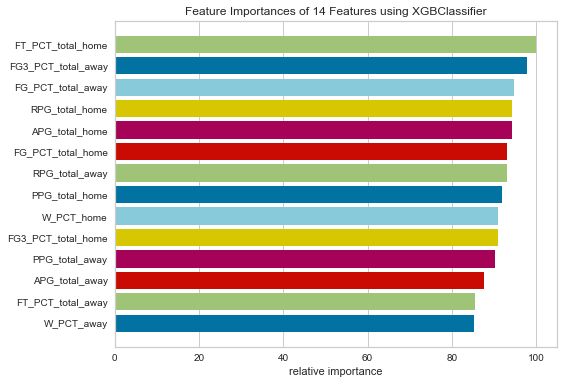

---------------------------------------------
Mean accuracy: 0.5036720911970594
Max accuracy: 0.505183585313175
Min accuracy: 0.5023758099352051
i=20
AST:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.54
              precision    recall  f1-score   support

           0       0.48      0.03      0.05      2120
           1       0.54      0.98      0.70      2510

    accuracy                           0.54      4630
   macro avg       0.51      0.50      0.37      4630
weighted avg       0.52      0.54      0.40      4630



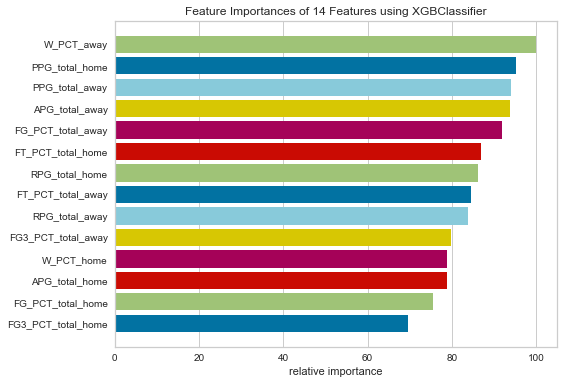

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.55
              precision    recall  f1-score   support

           0       0.41      0.03      0.05      2073
           1       0.55      0.97      0.70      2557

    accuracy                           0.55      4630
   macro avg       0.48      0.50      0.38      4630
weighted avg       0.49      0.55      0.41      4630



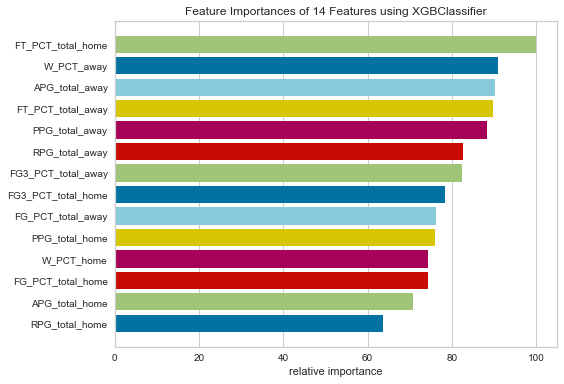

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.55
              precision    recall  f1-score   support

           0       0.47      0.03      0.05      2064
           1       0.55      0.97      0.71      2565

    accuracy                           0.55      4629
   macro avg       0.51      0.50      0.38      4629
weighted avg       0.52      0.55      0.42      4629



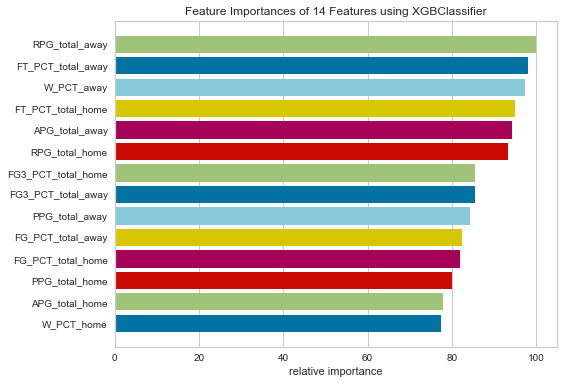

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.55
              precision    recall  f1-score   support

           0       0.48      0.08      0.14      2073
           1       0.55      0.93      0.69      2556

    accuracy                           0.55      4629
   macro avg       0.52      0.50      0.42      4629
weighted avg       0.52      0.55      0.45      4629



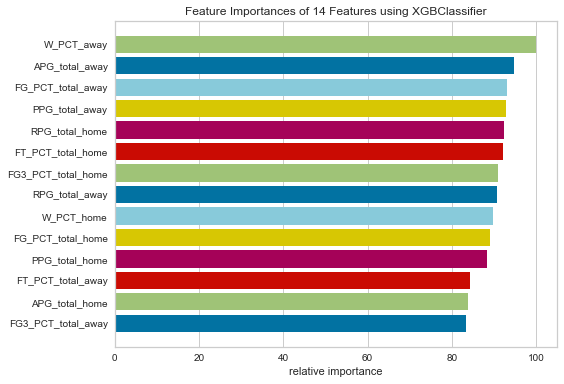

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.55
              precision    recall  f1-score   support

           0       0.47      0.05      0.08      2079
           1       0.55      0.96      0.70      2550

    accuracy                           0.55      4629
   macro avg       0.51      0.50      0.39      4629
weighted avg       0.52      0.55      0.42      4629



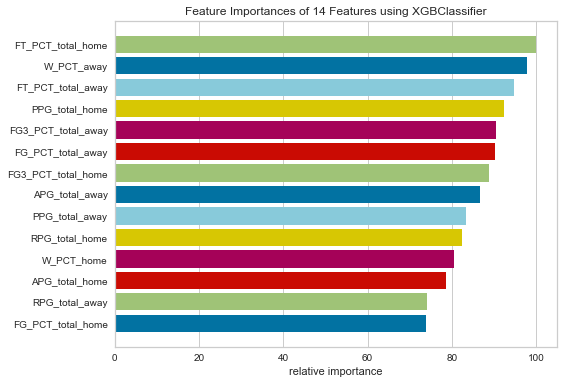

---------------------------------------------
Mean accuracy: 0.5475216694265236
Max accuracy: 0.5526031540289479
Min accuracy: 0.5412526997840172
i=25
REB:

Best XGBoost accuracy ({'learning_rate': 0.05}): 0.52
              precision    recall  f1-score   support

           0       0.42      0.13      0.20      2140
           1       0.53      0.85      0.65      2490

    accuracy                           0.52      4630
   macro avg       0.48      0.49      0.43      4630
weighted avg       0.48      0.52      0.44      4630



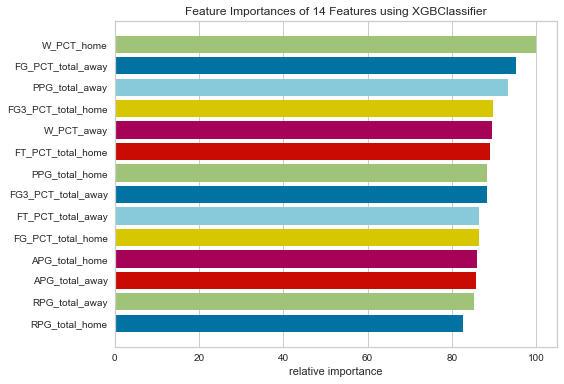

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.53
              precision    recall  f1-score   support

           0       0.47      0.05      0.09      2144
           1       0.54      0.95      0.69      2486

    accuracy                           0.53      4630
   macro avg       0.51      0.50      0.39      4630
weighted avg       0.51      0.53      0.41      4630



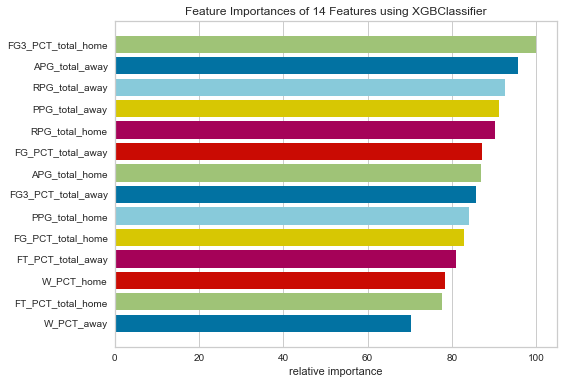

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.53
              precision    recall  f1-score   support

           0       0.44      0.05      0.09      2154
           1       0.53      0.95      0.68      2475

    accuracy                           0.53      4629
   macro avg       0.49      0.50      0.38      4629
weighted avg       0.49      0.53      0.41      4629



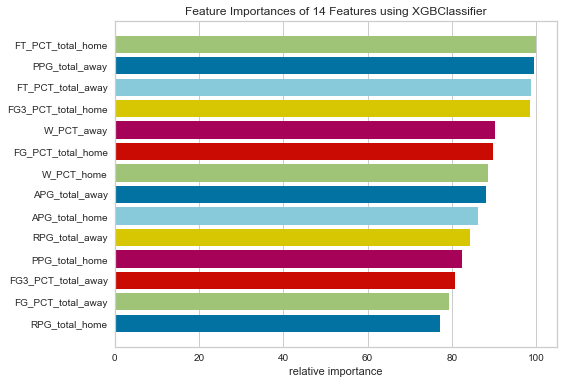

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'learning_rate': 0.6}): 0.50
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      2156
           1       0.53      0.58      0.55      2473

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



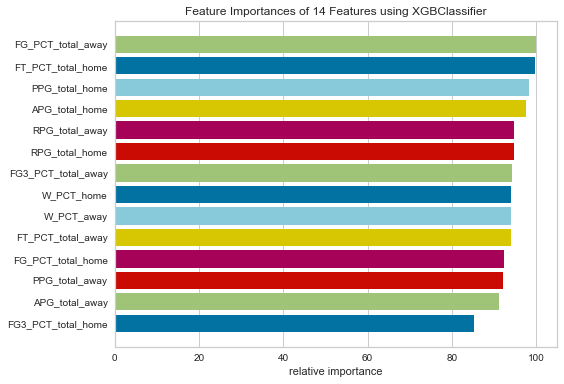

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'learning_rate': 0.01}): 0.52
              precision    recall  f1-score   support

           0       0.48      0.05      0.09      2192
           1       0.53      0.95      0.68      2437

    accuracy                           0.52      4629
   macro avg       0.50      0.50      0.38      4629
weighted avg       0.51      0.52      0.40      4629



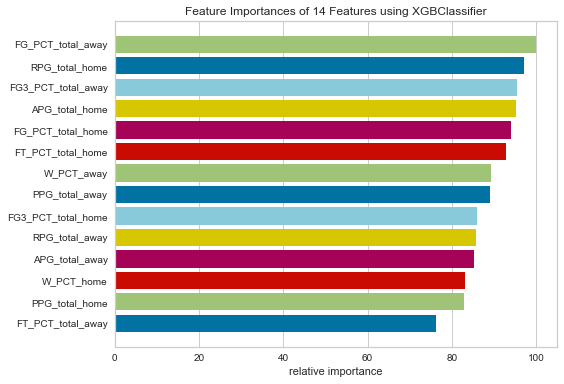

---------------------------------------------
Mean accuracy: 0.5199800114500237
Max accuracy: 0.534341252699784
Min accuracy: 0.5016202203499676


In [44]:
# Step size shrinkage used in update to prevent overfitting.  
# After each boosting step, we can directly get the weights of new features. 
# learnig rate shrinks the feature weights to make the boosting process more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'learning_rate' : [0.0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
})

## Try prune gamma

i=0
WINNER:

Best XGBoost accuracy ({'gamma': 13}): 0.58
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1953
           1       0.58      1.00      0.73      2677

    accuracy                           0.58      4630
   macro avg       0.29      0.50      0.37      4630
weighted avg       0.33      0.58      0.42      4630



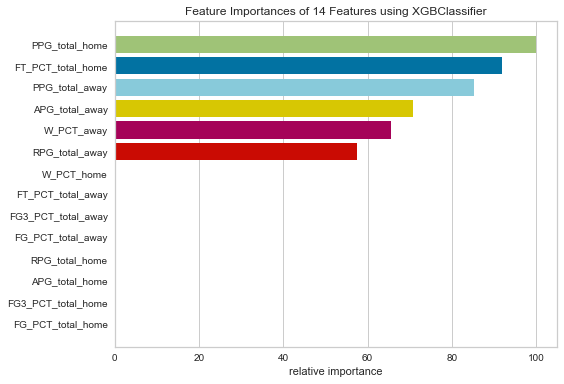

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'gamma': 27}): 0.60
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1865
           1       0.60      1.00      0.75      2765

    accuracy                           0.60      4630
   macro avg       0.30      0.50      0.37      4630
weighted avg       0.36      0.60      0.45      4630



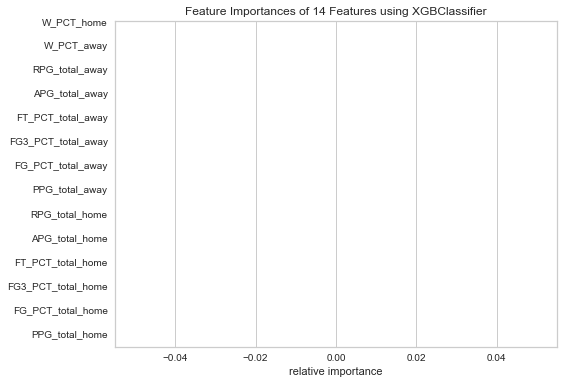

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'gamma': 21}): 0.60
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1836
           1       0.60      1.00      0.75      2793

    accuracy                           0.60      4629
   macro avg       0.30      0.50      0.38      4629
weighted avg       0.36      0.60      0.45      4629



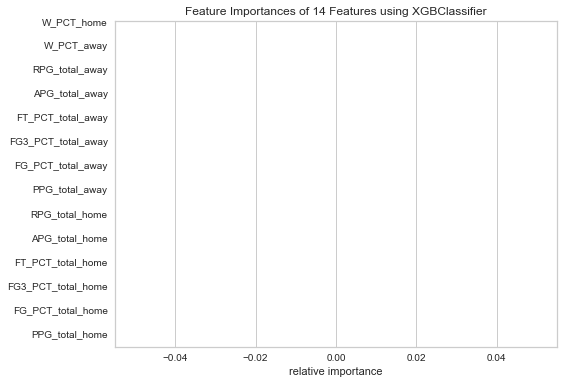

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'gamma': 29}): 0.60
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1871
           1       0.60      1.00      0.75      2758

    accuracy                           0.60      4629
   macro avg       0.30      0.50      0.37      4629
weighted avg       0.35      0.60      0.44      4629



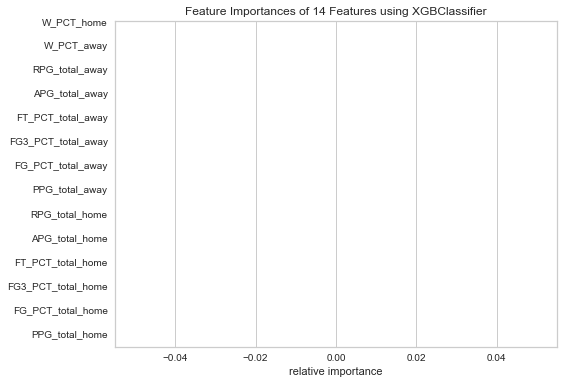

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'gamma': 13}): 0.59
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1913
           1       0.59      1.00      0.74      2716

    accuracy                           0.59      4629
   macro avg       0.29      0.50      0.37      4629
weighted avg       0.34      0.59      0.43      4629



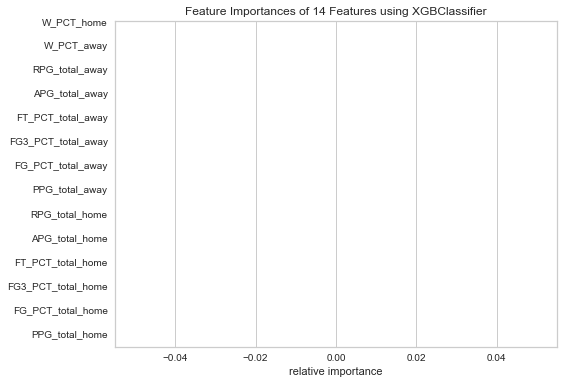

---------------------------------------------
Mean accuracy: 0.5936392645296089
Max accuracy: 0.6033700583279326
Min accuracy: 0.5781857451403888
i=5
FGP:

Best XGBoost accuracy ({'gamma': 21}): 0.54
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2122
           1       0.54      1.00      0.70      2508

    accuracy                           0.54      4630
   macro avg       0.27      0.50      0.35      4630
weighted avg       0.29      0.54      0.38      4630



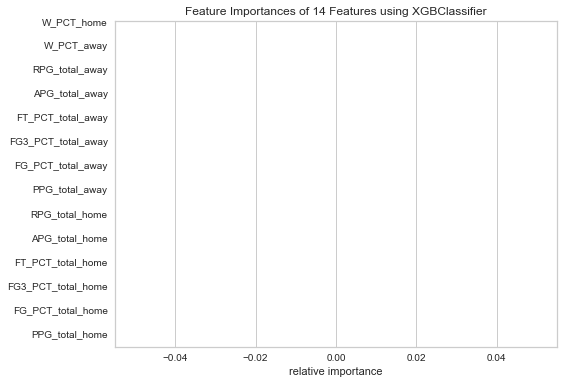

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'gamma': 22}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2071
           1       0.55      1.00      0.71      2559

    accuracy                           0.55      4630
   macro avg       0.28      0.50      0.36      4630
weighted avg       0.31      0.55      0.39      4630



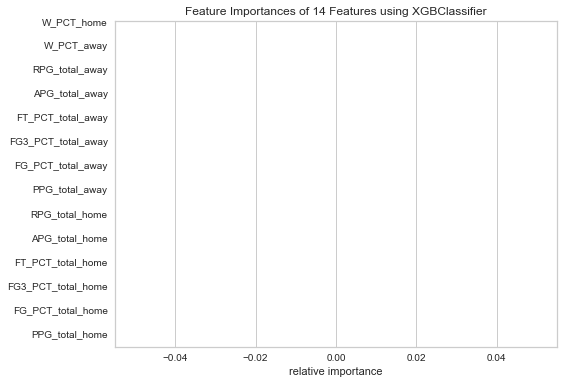

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'gamma': 17}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2082
           1       0.55      1.00      0.71      2547

    accuracy                           0.55      4629
   macro avg       0.28      0.50      0.35      4629
weighted avg       0.30      0.55      0.39      4629



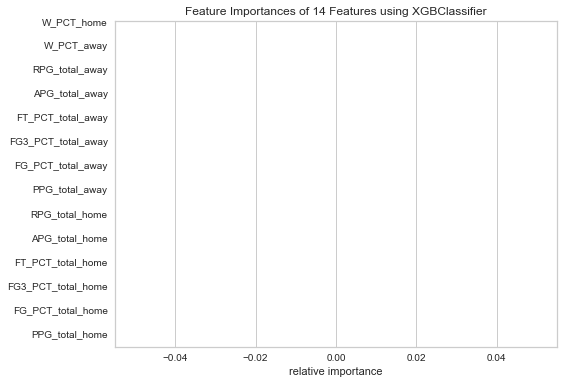

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'gamma': 15}): 0.56
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2041
           1       0.56      1.00      0.72      2588

    accuracy                           0.56      4629
   macro avg       0.28      0.50      0.36      4629
weighted avg       0.31      0.56      0.40      4629



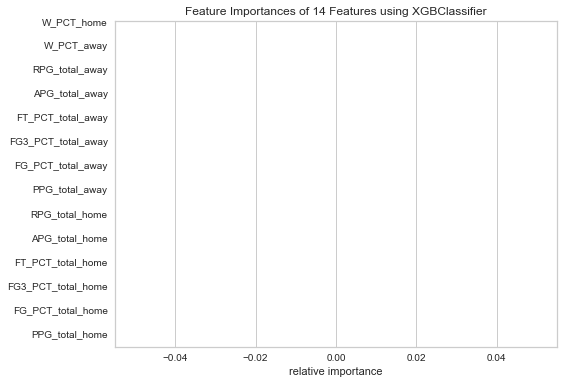

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'gamma': 19}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2060
           1       0.55      1.00      0.71      2569

    accuracy                           0.55      4629
   macro avg       0.28      0.50      0.36      4629
weighted avg       0.31      0.55      0.40      4629



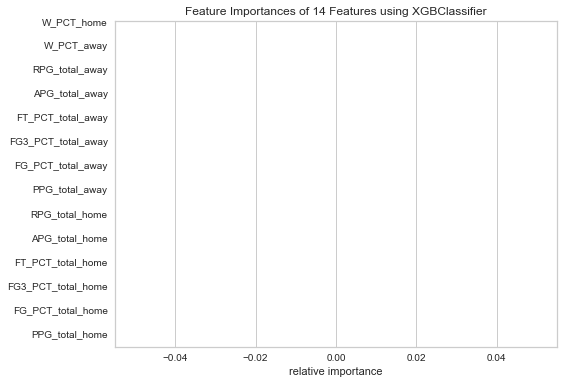

---------------------------------------------
Mean accuracy: 0.5509238288804685
Max accuracy: 0.5590840354288183
Min accuracy: 0.5416846652267818
i=10
FG3:

Best XGBoost accuracy ({'gamma': 28}): 0.51
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2266
           1       0.51      1.00      0.68      2364

    accuracy                           0.51      4630
   macro avg       0.26      0.50      0.34      4630
weighted avg       0.26      0.51      0.35      4630



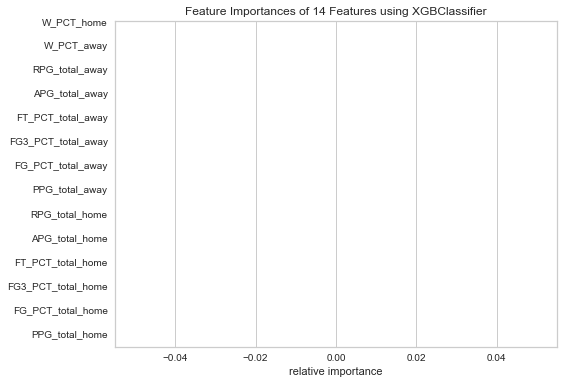

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'gamma': 27}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2292
           1       0.50      1.00      0.67      2338

    accuracy                           0.50      4630
   macro avg       0.25      0.50      0.34      4630
weighted avg       0.25      0.50      0.34      4630



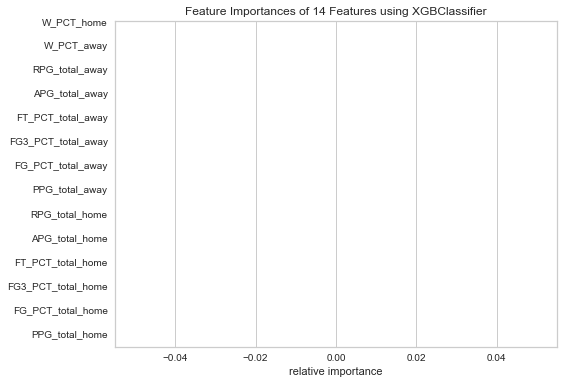

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.52
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2223
           1       0.52      1.00      0.68      2406

    accuracy                           0.52      4629
   macro avg       0.26      0.50      0.34      4629
weighted avg       0.27      0.52      0.36      4629



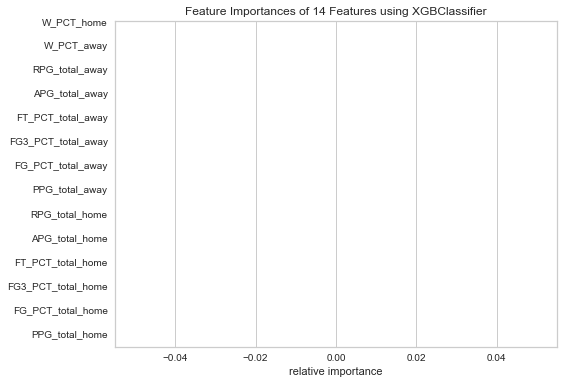

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'gamma': 14}): 0.51
              precision    recall  f1-score   support

           0       0.48      0.04      0.07      2265
           1       0.51      0.96      0.67      2364

    accuracy                           0.51      4629
   macro avg       0.50      0.50      0.37      4629
weighted avg       0.50      0.51      0.38      4629



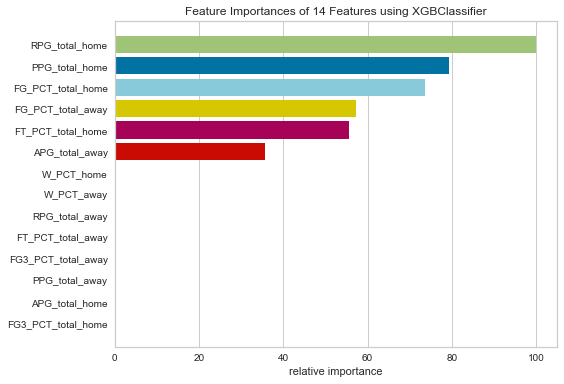

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'gamma': 24}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2324
           1       0.50      1.00      0.66      2305

    accuracy                           0.50      4629
   macro avg       0.25      0.50      0.33      4629
weighted avg       0.25      0.50      0.33      4629



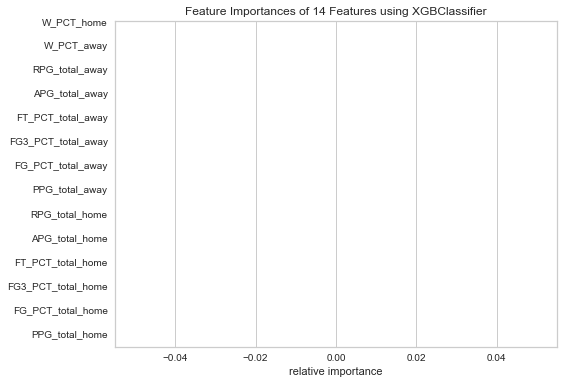

---------------------------------------------
Mean accuracy: 0.5111246732147365
Max accuracy: 0.5197666882696047
Min accuracy: 0.5049676025917926
i=15
FT:

Best XGBoost accuracy ({'gamma': 4}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2350
           1       0.49      0.47      0.48      2280

    accuracy                           0.50      4630
   macro avg       0.50      0.50      0.50      4630
weighted avg       0.50      0.50      0.50      4630



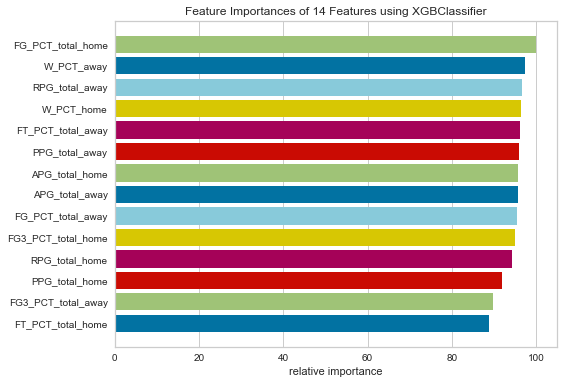

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2324
           1       0.00      0.00      0.00      2306

    accuracy                           0.50      4630
   macro avg       0.25      0.50      0.33      4630
weighted avg       0.25      0.50      0.34      4630



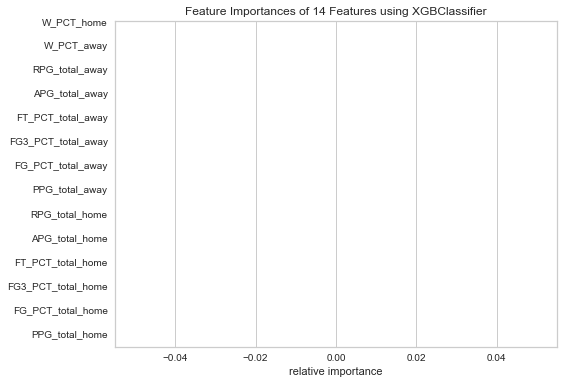

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2309
           1       0.00      0.00      0.00      2320

    accuracy                           0.50      4629
   macro avg       0.25      0.50      0.33      4629
weighted avg       0.25      0.50      0.33      4629



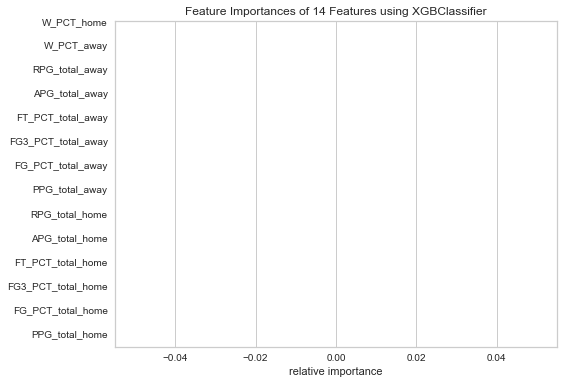

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'gamma': 25}): 0.52
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2390
           1       0.00      0.00      0.00      2239

    accuracy                           0.52      4629
   macro avg       0.26      0.50      0.34      4629
weighted avg       0.27      0.52      0.35      4629



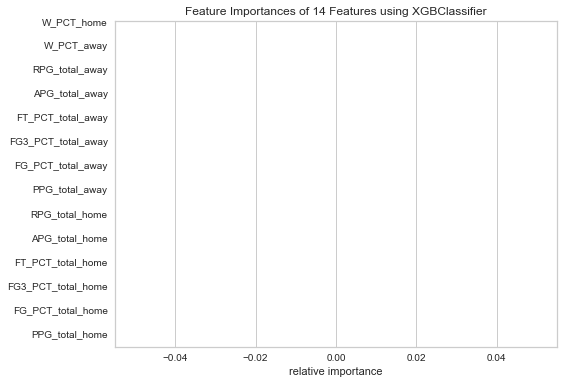

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'gamma': 23}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2332
           1       0.00      0.00      0.00      2297

    accuracy                           0.50      4629
   macro avg       0.25      0.50      0.34      4629
weighted avg       0.25      0.50      0.34      4629



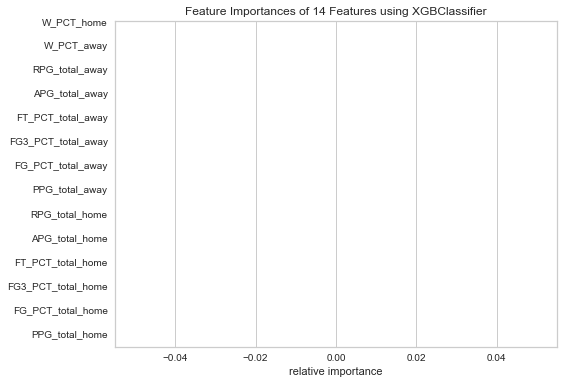

---------------------------------------------
Mean accuracy: 0.5034565400678509
Max accuracy: 0.5163102181896738
Min accuracy: 0.49676025917926564
i=20
AST:

Best XGBoost accuracy ({'gamma': 19}): 0.54
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2120
           1       0.54      1.00      0.70      2510

    accuracy                           0.54      4630
   macro avg       0.27      0.50      0.35      4630
weighted avg       0.29      0.54      0.38      4630



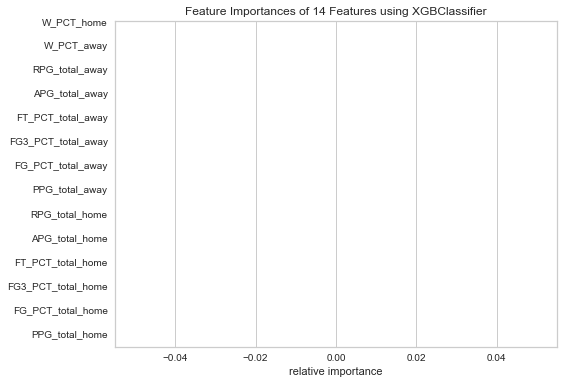

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'gamma': 22}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2073
           1       0.55      1.00      0.71      2557

    accuracy                           0.55      4630
   macro avg       0.28      0.50      0.36      4630
weighted avg       0.30      0.55      0.39      4630



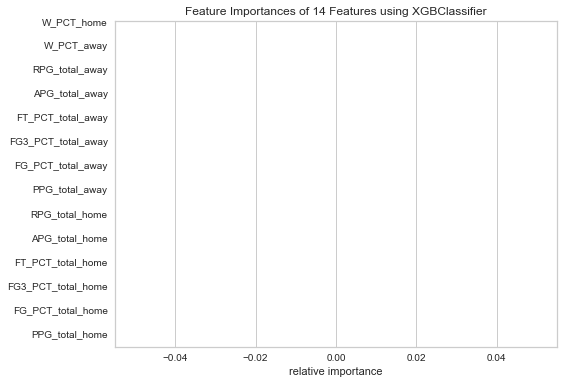

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'gamma': 21}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2064
           1       0.55      1.00      0.71      2565

    accuracy                           0.55      4629
   macro avg       0.28      0.50      0.36      4629
weighted avg       0.31      0.55      0.40      4629



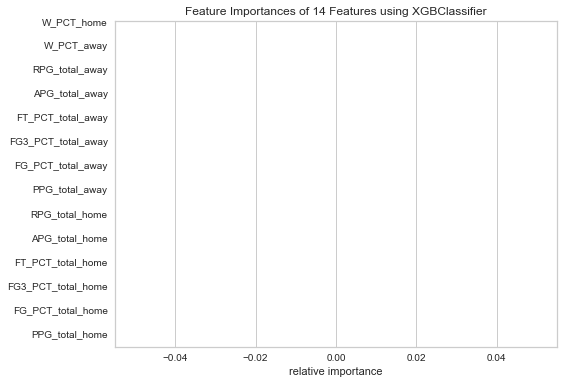

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'gamma': 25}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2073
           1       0.55      1.00      0.71      2556

    accuracy                           0.55      4629
   macro avg       0.28      0.50      0.36      4629
weighted avg       0.30      0.55      0.39      4629



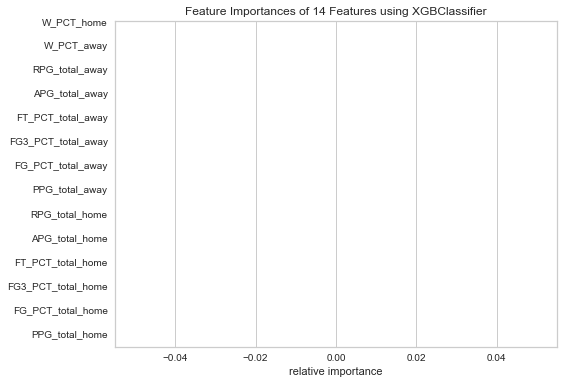

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'gamma': 22}): 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2079
           1       0.55      1.00      0.71      2550

    accuracy                           0.55      4629
   macro avg       0.28      0.50      0.36      4629
weighted avg       0.30      0.55      0.39      4629



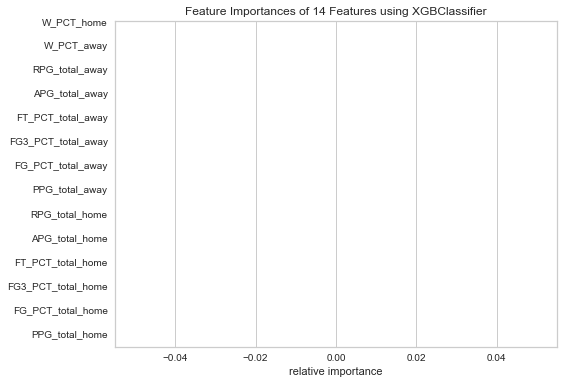

---------------------------------------------
Mean accuracy: 0.5501677260504837
Max accuracy: 0.5541153596889177
Min accuracy: 0.5421166306695464
i=25
REB:

Best XGBoost accuracy ({'gamma': 22}): 0.54
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2140
           1       0.54      1.00      0.70      2490

    accuracy                           0.54      4630
   macro avg       0.27      0.50      0.35      4630
weighted avg       0.29      0.54      0.38      4630



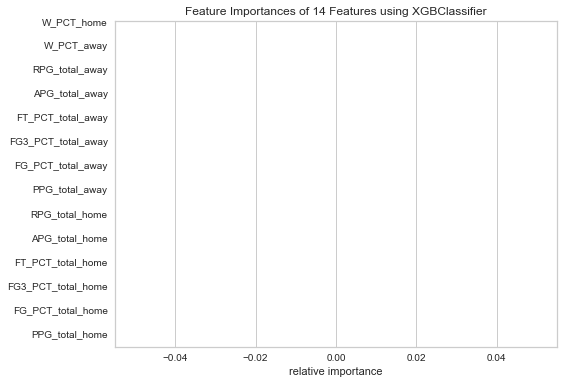

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'gamma': 19}): 0.54
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2144
           1       0.54      1.00      0.70      2486

    accuracy                           0.54      4630
   macro avg       0.27      0.50      0.35      4630
weighted avg       0.29      0.54      0.38      4630



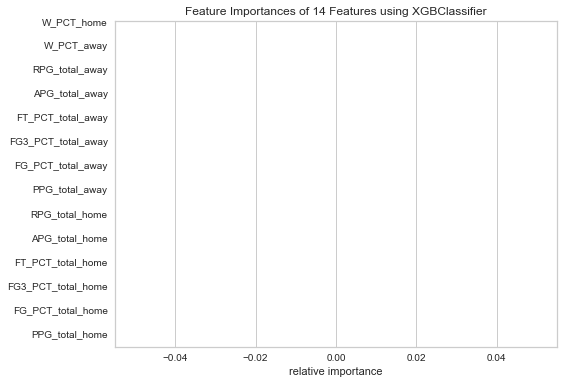

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'gamma': 16}): 0.53
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2154
           1       0.53      1.00      0.70      2475

    accuracy                           0.53      4629
   macro avg       0.27      0.50      0.35      4629
weighted avg       0.29      0.53      0.37      4629



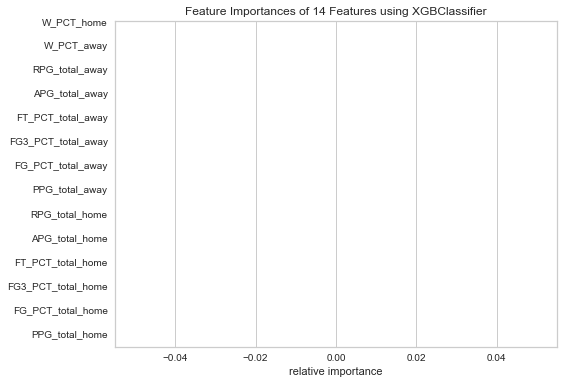

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'gamma': 24}): 0.53
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2156
           1       0.53      1.00      0.70      2473

    accuracy                           0.53      4629
   macro avg       0.27      0.50      0.35      4629
weighted avg       0.29      0.53      0.37      4629



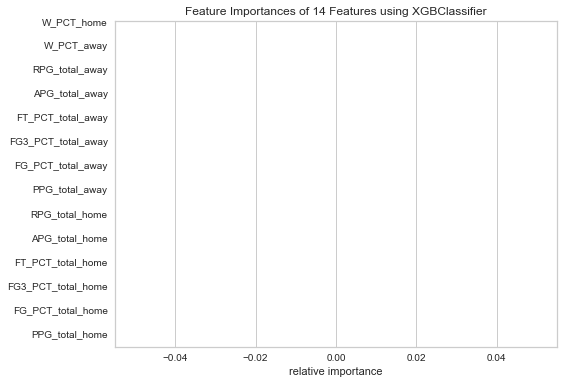

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'gamma': 25}): 0.53
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2192
           1       0.53      1.00      0.69      2437

    accuracy                           0.53      4629
   macro avg       0.26      0.50      0.34      4629
weighted avg       0.28      0.53      0.36      4629



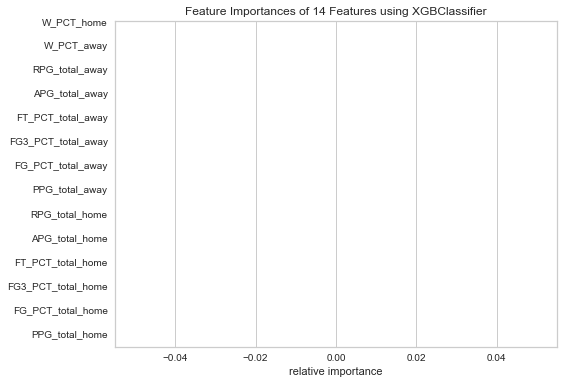

---------------------------------------------
Mean accuracy: 0.5359108484542234
Max accuracy: 0.5377969762419006
Min accuracy: 0.5342406567293152


In [45]:
# Minimum loss reduction required to make a further partition on a leaf node of the tree. 
# The larger gamma is, the more conservative the algorithm will be.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'gamma' : [*range(0,30)],
})

## Try prune scale_pos_weight

i=0
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 23}): 0.58
              precision    recall  f1-score   support

           0       0.45      0.02      0.03      1953
           1       0.58      0.98      0.73      2677

    accuracy                           0.58      4630
   macro avg       0.51      0.50      0.38      4630
weighted avg       0.52      0.58      0.44      4630



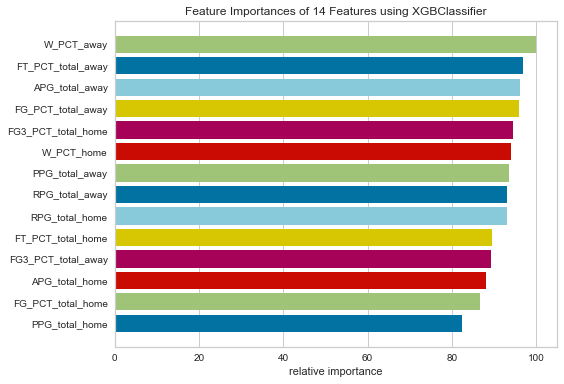

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 18}): 0.59
              precision    recall  f1-score   support

           0       0.40      0.02      0.04      1865
           1       0.60      0.98      0.74      2765

    accuracy                           0.59      4630
   macro avg       0.50      0.50      0.39      4630
weighted avg       0.52      0.59      0.46      4630



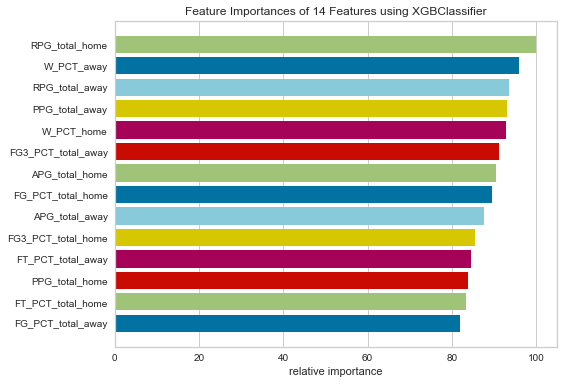

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 22}): 0.60
              precision    recall  f1-score   support

           0       0.38      0.02      0.03      1836
           1       0.60      0.98      0.75      2793

    accuracy                           0.60      4629
   macro avg       0.49      0.50      0.39      4629
weighted avg       0.51      0.60      0.46      4629



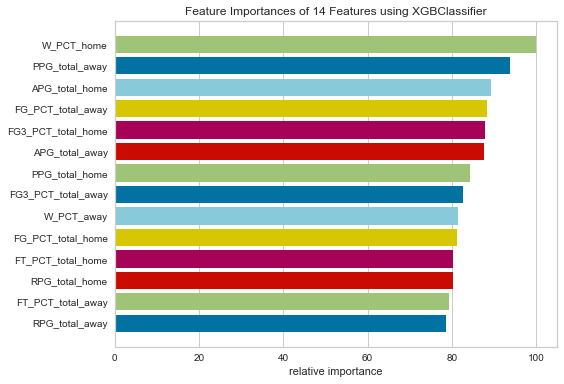

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 21}): 0.59
              precision    recall  f1-score   support

           0       0.42      0.02      0.04      1871
           1       0.60      0.98      0.74      2758

    accuracy                           0.59      4629
   macro avg       0.51      0.50      0.39      4629
weighted avg       0.52      0.59      0.46      4629



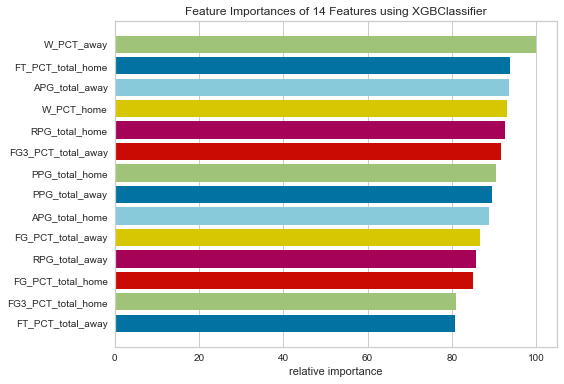

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 21}): 0.59
              precision    recall  f1-score   support

           0       0.47      0.02      0.03      1913
           1       0.59      0.99      0.74      2716

    accuracy                           0.59      4629
   macro avg       0.53      0.50      0.38      4629
weighted avg       0.54      0.59      0.44      4629



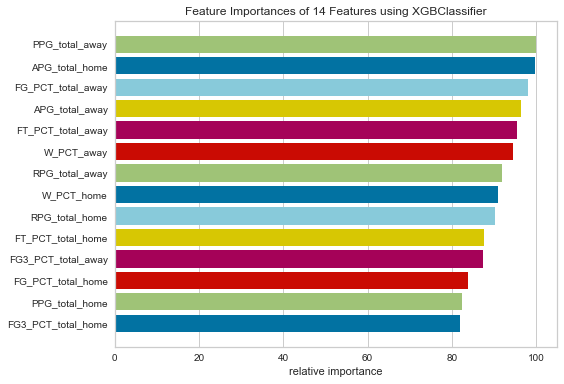

---------------------------------------------
Mean accuracy: 0.5901291370442795
Max accuracy: 0.5990494707280191
Min accuracy: 0.5764578833693305
i=5
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 15}): 0.54
              precision    recall  f1-score   support

           0       0.52      0.03      0.05      2122
           1       0.54      0.98      0.70      2508

    accuracy                           0.54      4630
   macro avg       0.53      0.50      0.38      4630
weighted avg       0.53      0.54      0.40      4630



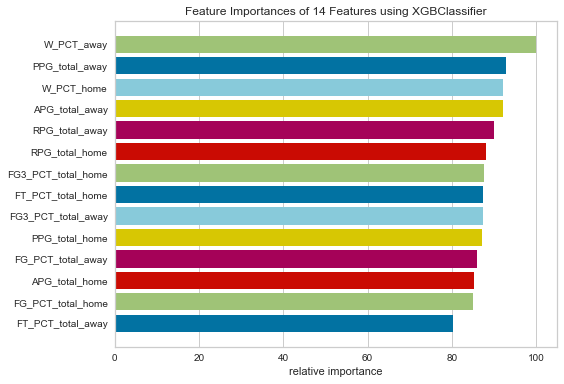

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.55
              precision    recall  f1-score   support

           0       0.45      0.03      0.06      2071
           1       0.55      0.97      0.70      2559

    accuracy                           0.55      4630
   macro avg       0.50      0.50      0.38      4630
weighted avg       0.51      0.55      0.42      4630



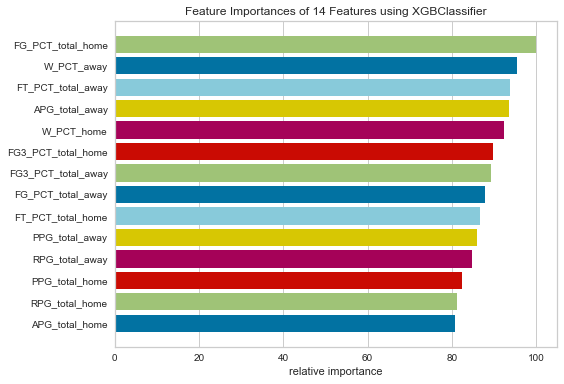

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 27}): 0.55
              precision    recall  f1-score   support

           0       0.38      0.02      0.03      2082
           1       0.55      0.98      0.70      2547

    accuracy                           0.55      4629
   macro avg       0.47      0.50      0.37      4629
weighted avg       0.48      0.55      0.40      4629



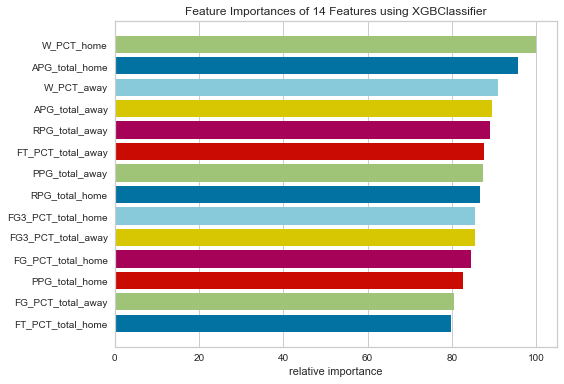

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.56
              precision    recall  f1-score   support

           0       0.44      0.02      0.04      2041
           1       0.56      0.98      0.71      2588

    accuracy                           0.56      4629
   macro avg       0.50      0.50      0.38      4629
weighted avg       0.51      0.56      0.42      4629



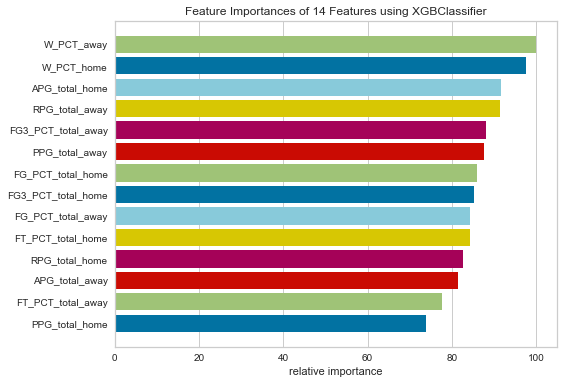

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.55
              precision    recall  f1-score   support

           0       0.45      0.04      0.07      2060
           1       0.56      0.96      0.70      2569

    accuracy                           0.55      4629
   macro avg       0.50      0.50      0.39      4629
weighted avg       0.51      0.55      0.42      4629



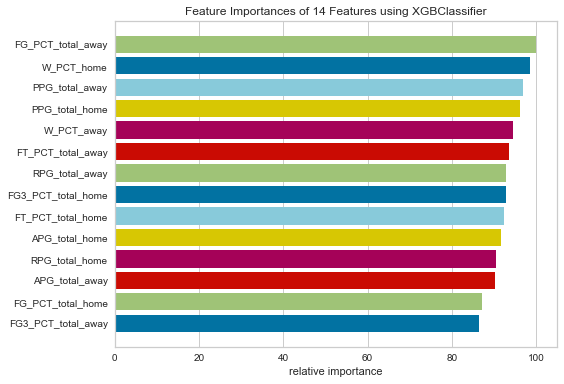

---------------------------------------------
Mean accuracy: 0.5484936383313573
Max accuracy: 0.5564916828688702
Min accuracy: 0.542548596112311
i=10
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 16}): 0.51
              precision    recall  f1-score   support

           0       0.55      0.04      0.07      2266
           1       0.51      0.97      0.67      2364

    accuracy                           0.51      4630
   macro avg       0.53      0.50      0.37      4630
weighted avg       0.53      0.51      0.38      4630



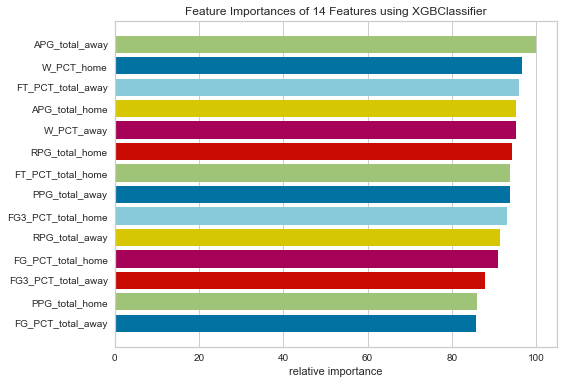

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 15}): 0.50
              precision    recall  f1-score   support

           0       0.41      0.03      0.06      2292
           1       0.50      0.96      0.66      2338

    accuracy                           0.50      4630
   macro avg       0.46      0.49      0.36      4630
weighted avg       0.46      0.50      0.36      4630



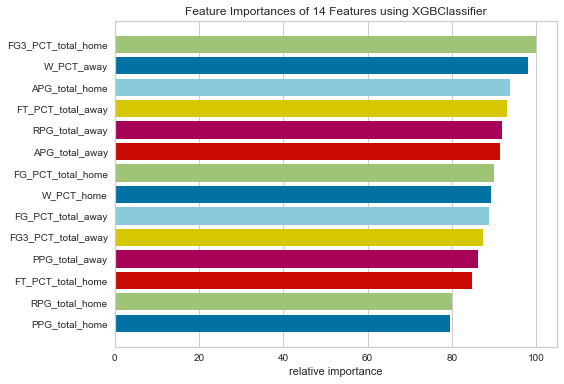

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 24}): 0.52
              precision    recall  f1-score   support

           0       0.47      0.04      0.07      2223
           1       0.52      0.96      0.67      2406

    accuracy                           0.52      4629
   macro avg       0.49      0.50      0.37      4629
weighted avg       0.49      0.52      0.38      4629



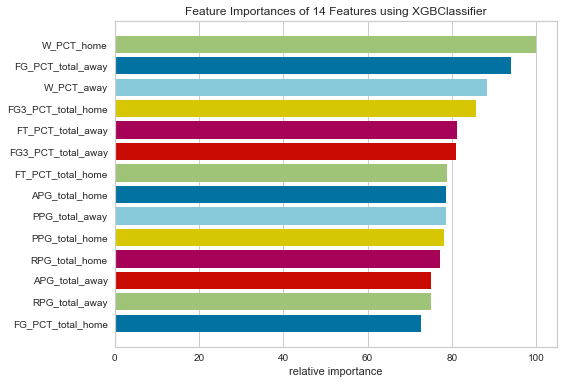

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 22}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.03      0.06      2265
           1       0.51      0.97      0.67      2364

    accuracy                           0.51      4629
   macro avg       0.51      0.50      0.36      4629
weighted avg       0.51      0.51      0.37      4629



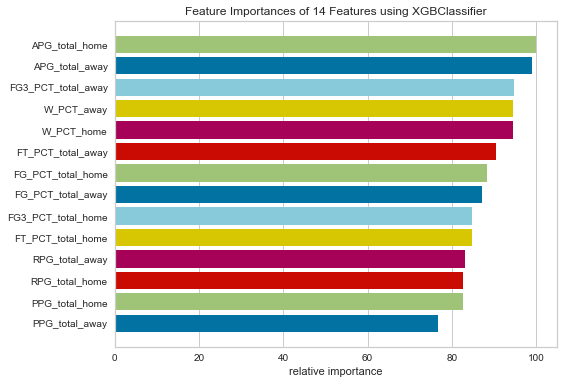

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 17}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.03      0.06      2324
           1       0.50      0.96      0.66      2305

    accuracy                           0.50      4629
   macro avg       0.49      0.50      0.36      4629
weighted avg       0.49      0.50      0.36      4629



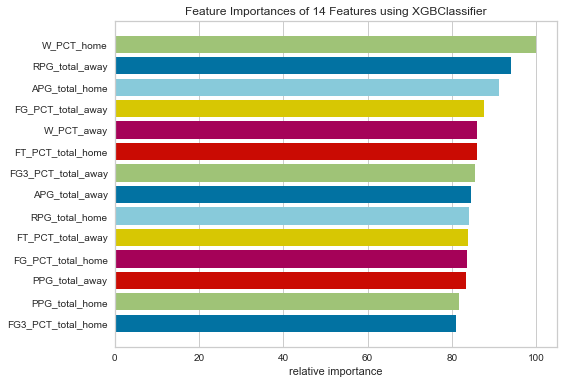

---------------------------------------------
Mean accuracy: 0.5102067116549017
Max accuracy: 0.5173903650896522
Min accuracy: 0.49848812095032397
i=15
FT:

Best XGBoost accuracy ({'scale_pos_weight': 15}): 0.50
              precision    recall  f1-score   support

           0       0.54      0.04      0.07      2350
           1       0.49      0.97      0.65      2280

    accuracy                           0.50      4630
   macro avg       0.52      0.50      0.36      4630
weighted avg       0.52      0.50      0.36      4630



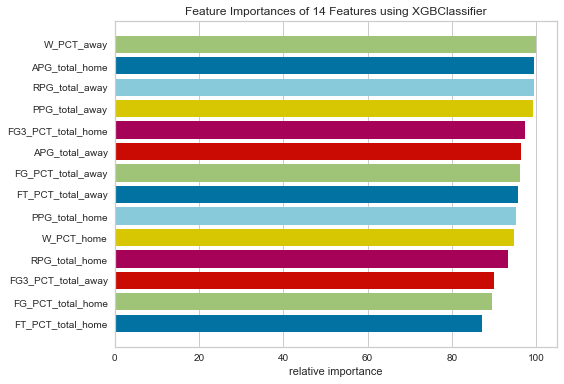

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2324
           1       0.00      0.00      0.00      2306

    accuracy                           0.50      4630
   macro avg       0.25      0.50      0.33      4630
weighted avg       0.25      0.50      0.34      4630



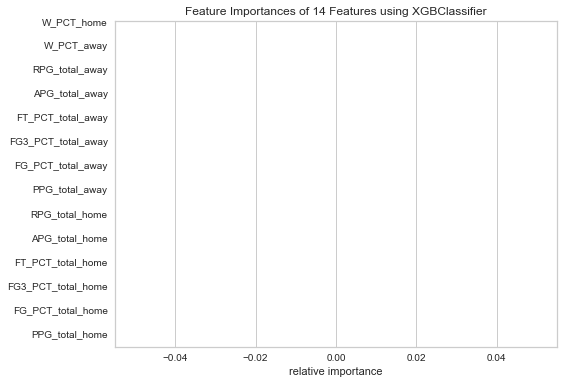

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2309
           1       0.50      0.46      0.48      2320

    accuracy                           0.50      4629
   macro avg       0.50      0.50      0.50      4629
weighted avg       0.50      0.50      0.50      4629



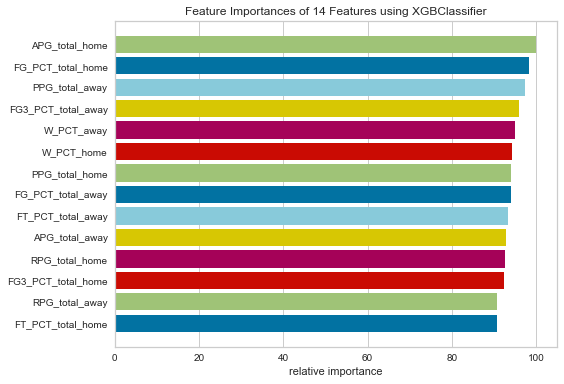

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'scale_pos_weight': 6}): 0.48
              precision    recall  f1-score   support

           0       0.48      0.06      0.10      2390
           1       0.48      0.93      0.63      2239

    accuracy                           0.48      4629
   macro avg       0.48      0.50      0.37      4629
weighted avg       0.48      0.48      0.36      4629



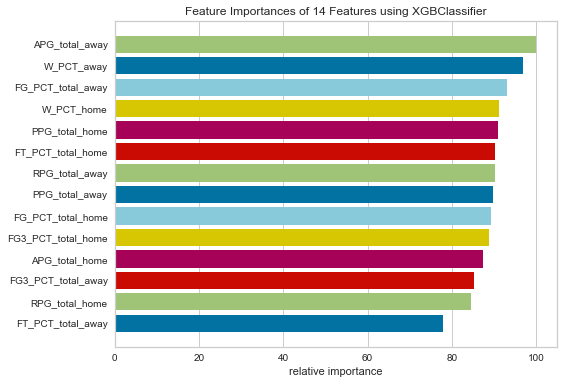

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2332
           1       0.00      0.00      0.00      2297

    accuracy                           0.50      4629
   macro avg       0.25      0.50      0.34      4629
weighted avg       0.25      0.50      0.34      4629



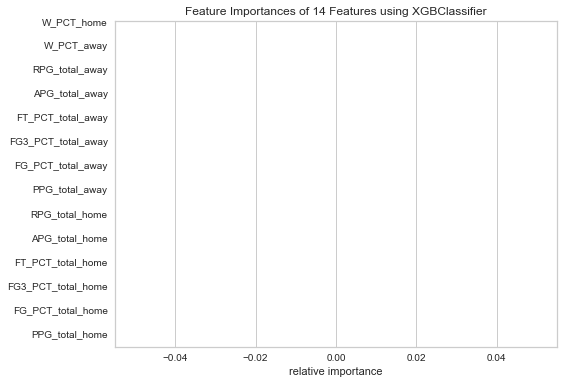

---------------------------------------------
Mean accuracy: 0.49454542146025593
Max accuracy: 0.5019438444924406
Min accuracy: 0.48088139987038236
i=20
AST:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.02      0.04      2120
           1       0.54      0.98      0.70      2510

    accuracy                           0.54      4630
   macro avg       0.54      0.50      0.37      4630
weighted avg       0.54      0.54      0.40      4630



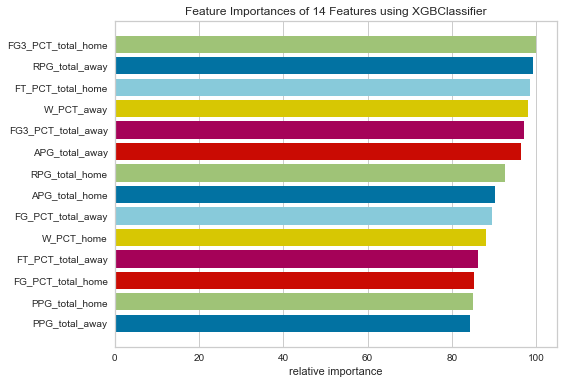

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'scale_pos_weight': 12}): 0.55
              precision    recall  f1-score   support

           0       0.39      0.03      0.05      2073
           1       0.55      0.97      0.70      2557

    accuracy                           0.55      4630
   macro avg       0.47      0.50      0.37      4630
weighted avg       0.48      0.55      0.41      4630



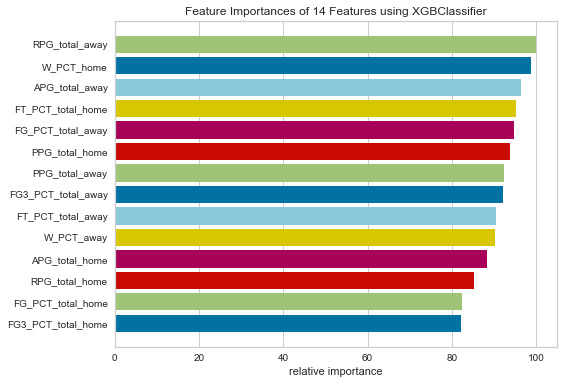

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.55
              precision    recall  f1-score   support

           0       0.47      0.02      0.04      2064
           1       0.55      0.98      0.71      2565

    accuracy                           0.55      4629
   macro avg       0.51      0.50      0.37      4629
weighted avg       0.52      0.55      0.41      4629



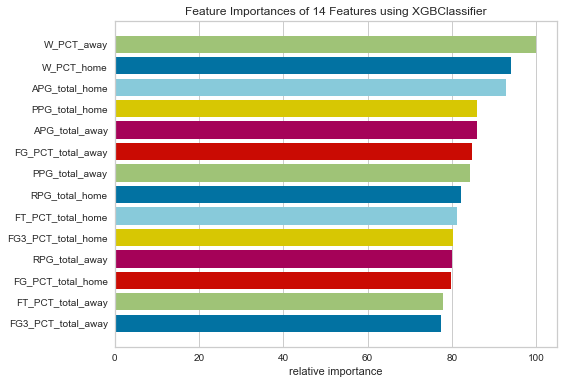

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'scale_pos_weight': 22}): 0.55
              precision    recall  f1-score   support

           0       0.49      0.02      0.04      2073
           1       0.55      0.98      0.71      2556

    accuracy                           0.55      4629
   macro avg       0.52      0.50      0.37      4629
weighted avg       0.53      0.55      0.41      4629



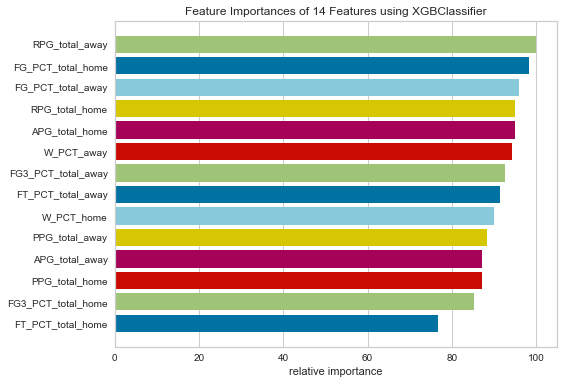

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'scale_pos_weight': 13}): 0.54
              precision    recall  f1-score   support

           0       0.37      0.02      0.04      2079
           1       0.55      0.97      0.70      2550

    accuracy                           0.54      4629
   macro avg       0.46      0.50      0.37      4629
weighted avg       0.47      0.54      0.40      4629



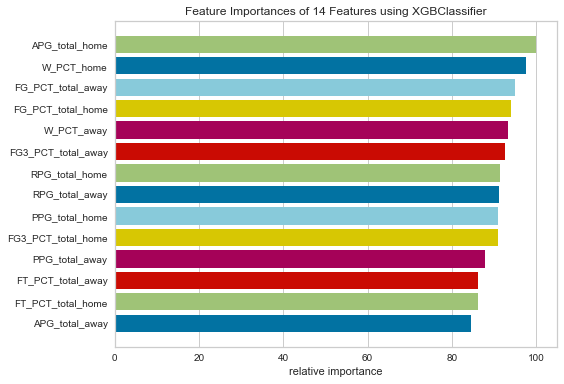

---------------------------------------------
Mean accuracy: 0.5487097726932332
Max accuracy: 0.5530352127889393
Min accuracy: 0.5438444924406047
i=25
REB:

Best XGBoost accuracy ({'scale_pos_weight': 16}): 0.54
              precision    recall  f1-score   support

           0       0.48      0.04      0.07      2140
           1       0.54      0.97      0.69      2490

    accuracy                           0.54      4630
   macro avg       0.51      0.50      0.38      4630
weighted avg       0.51      0.54      0.40      4630



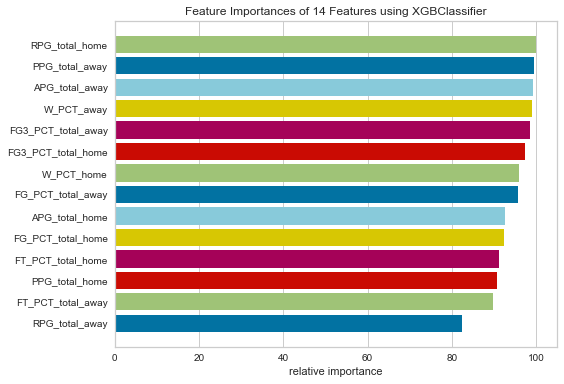

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'scale_pos_weight': 24}): 0.54
              precision    recall  f1-score   support

           0       0.51      0.03      0.05      2144
           1       0.54      0.98      0.69      2486

    accuracy                           0.54      4630
   macro avg       0.52      0.50      0.37      4630
weighted avg       0.52      0.54      0.40      4630



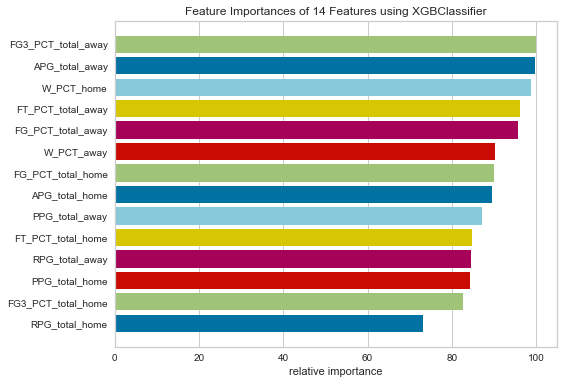

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'scale_pos_weight': 19}): 0.53
              precision    recall  f1-score   support

           0       0.47      0.03      0.05      2154
           1       0.53      0.97      0.69      2475

    accuracy                           0.53      4629
   macro avg       0.50      0.50      0.37      4629
weighted avg       0.50      0.53      0.39      4629



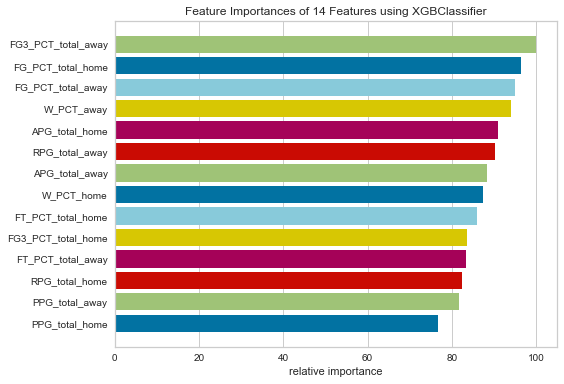

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.53
              precision    recall  f1-score   support

           0       0.48      0.02      0.05      2156
           1       0.53      0.98      0.69      2473

    accuracy                           0.53      4629
   macro avg       0.51      0.50      0.37      4629
weighted avg       0.51      0.53      0.39      4629



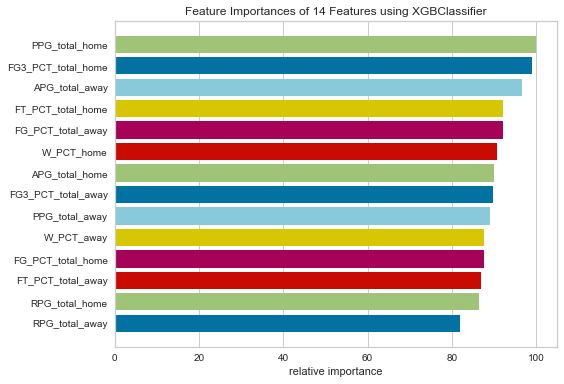

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'scale_pos_weight': 27}): 0.53
              precision    recall  f1-score   support

           0       0.56      0.02      0.04      2192
           1       0.53      0.98      0.69      2437

    accuracy                           0.53      4629
   macro avg       0.55      0.50      0.37      4629
weighted avg       0.54      0.53      0.38      4629



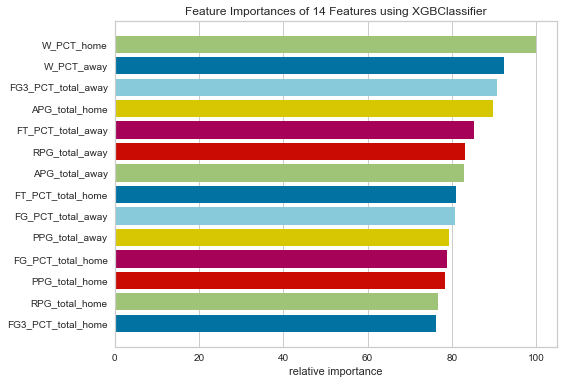

---------------------------------------------
Mean accuracy: 0.5350467659282008
Max accuracy: 0.5373650107991361
Min accuracy: 0.5329444804493411


In [46]:
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'scale_pos_weight' : [*range(0,30)],
})